<div class="alert alert-block alert-info">

# Customer Churn Prediction

## FIT5149 Assignment1
    
#### Student Name: Madeleine Chalmers
#### Student ID: 31222846

Date: 26 October 2021

    
</div>

<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Introduction](#Intro) <br>
[2. EDA](#task1) <br>
$\;\;\;\;$[2.1. Univariate analysis](#Univariate) <br>
$\;\;\;\;$[2.1. Summary of Univariate analysis](#SumUnivariate) <br>
$\;\;\;\;$[2.2. Bivariate analysis](#Bivariate) <br>
$\;\;\;\;$[2.2. Summary of Bivariate analysis](#SumBivariate) <br>
$\;\;\;\;$[2.2. Multivariate analysis](#Multivariate) <br>
$\;\;\;\;$[2.2. Summary of Multivariate analysis](#SumMultivariate) <br>
$\;\;\;\;$[2.3. More](#More) <br>
$\;\;\;\;$[2.4. Summary](#Summary) <br>
[3. Model Development](#MD) <br>
[4. Model Scoring on Test Data](#MScore) <br>
[5. Model Interpretation and Inference](#MInterp) <br>
[6. Variable Importance](#VarImp) <br>
[7. Marketing Suggestions](#MarktSugst) <br>
[8. Conclusion](#Conclusion) <br>
[9. References](#Ref) <br>

<div class="alert alert-block alert-warning">

<br>    
    
## 1.  Introduction  <a class="anchor" name="Intro">
    
</a>
</div>
    
The aim here is to build a statistical model which will accurately predict when an insurance company is about to lose their customer. There are sixteen anonymised features in the dataset and one response variable (named 'labels') which indicates churn (1) or no churn (0) for each observation. Two datasets are provided for training (trainSet.csv) and testing (testSet.csv) the models. <br><br>

Data Source: https://www.kaggle.com/mukulsingh/insurance-churn-prediction <br><br>

Section 1: Exploratory data analsis is completed in this section. The data is characterised with single variable exploration, then relationships are explored through correlation and graphical analysis. Findings are discussed along the way and summarised at the end. <br><br>

Section 2: Models which are strong candidates for effective statistical learning given the data discoveries we have made are discussed. The code and development process for two classificaltion model varieties as well as any data transformations required to run them are included, such as one hot encoding and standard scaling of features.<br><br>

Section 3: The final model(s) results are presented and interpreted at the end. Performance metrics are discussed and key features that are strongly associated with the response variable are identified and discussed.<br><br>

Load the required libraries:

In [1]:
library(psych)
#library(GGally) 
library(ggplot2)
library(reshape2)
#library(corrgram)
library(OneR)
library(RColorBrewer)
library(corrplot)
library(gridExtra) 


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'OneR' was built under R version 3.6.3"corrplot 0.90 loaded
Warning message:
"package 'gridExtra' was built under R version 3.6.3"

package installations:

In [2]:
#install.packages("psych")
#install.packages("reshape2")
#install.packages("OneR")
#install.packages("ggplot2")
#install.packages("tidyverse")
#install.packages("corrplot")
#install.packages("gridExtra")
#install.packages("")

Read in the test and train datasets that were provided.

In [3]:
# load test dataset
test <- read.csv(file = 'testSet.csv',stringsAsFactors = TRUE)

# load train dataset
train <-  read.csv(file = 'trainSet.csv',stringsAsFactors = TRUE)

<div class="alert alert-block alert-success">

<br>
    
## 2. Exploatory Data Analysis <a class="anchor" name="task1">
    
<br>
    
</a>

#### Using Exploratory Data Analysis (EDA) we will:

1. Explore individual variables, their characteristics such as spread, variance, distribution etc.
2. Identify important features which have a relationship with our label, and how they interact.
3. Explore the qualities of the relationships to identify which models will give strongest results, and how we can transform the data to aid with learning.
4. Identify features with no relationship and exclude them from our models, for improved efficiency and reduced over fitting.
5. Identify features which strongly correlate with one another, to eliminate duplicate information. 
6. Build effective models which are supported by our exploration.

First look at the data

In [4]:
# show the first rows
head(train)

feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
1.5127910,-0.2434605,0.1434182,2.01858846,0.07622994,-0.4114531,-0.2519404,1,1,1,0,1,0,0,0,3,0
-1.5007763,-0.2125875,1.2248391,-0.15984112,-0.56935064,-0.4114531,-0.2519404,8,2,1,0,0,0,0,8,3,0
0.9477471,0.5812426,-0.3372133,0.77987360,-0.56935064,-0.4114531,-0.2519404,0,2,1,0,0,0,2,8,3,0
-0.8415585,-0.2217837,0.5038918,-0.37729577,0.39902023,-0.4114531,-0.2519404,9,1,1,0,0,0,0,1,3,0
-0.5590365,-0.5922597,-1.1783185,-0.41612696,-0.56935064,-0.4114531,-0.2519404,1,2,1,0,1,0,0,8,3,0
0.9477471,-0.4654833,-0.5775291,0.08867847,-0.24656035,2.2551433,2.3528870,4,2,2,1,1,0,0,8,0,0


Check the data types.

In [5]:
# show training the data structure
str(train)

'data.frame':	27126 obs. of  17 variables:
 $ feature_0 : num  1.513 -1.501 0.948 -0.842 -0.559 ...
 $ feature_1 : num  -0.243 -0.213 0.581 -0.222 -0.592 ...
 $ feature_2 : num  0.143 1.225 -0.337 0.504 -1.178 ...
 $ feature_3 : num  2.019 -0.16 0.78 -0.377 -0.416 ...
 $ feature_4 : num  0.0762 -0.5694 -0.5694 0.399 -0.5694 ...
 $ feature_5 : num  -0.411 -0.411 -0.411 -0.411 -0.411 ...
 $ feature_6 : num  -0.252 -0.252 -0.252 -0.252 -0.252 ...
 $ feature_7 : int  1 8 0 9 1 4 7 6 6 9 ...
 $ feature_8 : int  1 2 2 1 2 2 1 1 1 1 ...
 $ feature_9 : int  1 1 1 1 1 2 1 2 1 3 ...
 $ feature_10: int  0 0 0 0 0 1 0 0 0 0 ...
 $ feature_11: int  1 0 0 0 1 1 0 1 1 1 ...
 $ feature_12: int  0 0 0 0 0 0 0 1 1 0 ...
 $ feature_13: int  0 0 2 0 0 0 0 2 0 0 ...
 $ feature_14: int  0 8 8 1 8 8 1 6 5 9 ...
 $ feature_15: int  3 3 3 3 3 0 3 3 3 3 ...
 $ labels    : int  0 0 0 0 0 0 0 0 0 0 ...


We want to be certain that the two test and train datasets are compatible with one another. Do they have the same data types? The same features in each?

In [6]:
# Show the testing data structure 
str(test)

'data.frame':	6782 obs. of  17 variables:
 $ feature_0 : num  -1.03 -0.842 -1.501 -0.277 -0.936 ...
 $ feature_1 : num  -0.222 -0.356 -0.265 -0.402 -0.268 ...
 $ feature_2 : num  0.504 -1.539 -1.419 1.826 1.585 ...
 $ feature_3 : num  -0.9054 -0.1055 0.3993 -0.8976 0.0537 ...
 $ feature_4 : num  0.0762 2.9813 -0.5694 6.2092 -0.5694 ...
 $ feature_5 : num  -0.411 -0.411 -0.411 -0.411 -0.411 ...
 $ feature_6 : num  -0.252 -0.252 -0.252 -0.252 -0.252 ...
 $ feature_7 : int  0 0 7 0 0 7 5 9 4 1 ...
 $ feature_8 : int  1 1 2 1 2 2 1 1 1 1 ...
 $ feature_9 : int  1 1 1 1 1 1 1 1 2 1 ...
 $ feature_10: int  0 0 0 0 0 0 0 0 0 0 ...
 $ feature_11: int  1 1 1 1 1 1 0 1 1 1 ...
 $ feature_12: int  0 0 1 0 0 1 0 0 0 1 ...
 $ feature_13: int  2 2 2 0 0 2 0 2 0 2 ...
 $ feature_14: int  6 6 6 5 4 8 1 8 3 8 ...
 $ feature_15: int  3 3 3 3 3 3 3 3 3 3 ...
 $ labels    : int  0 0 0 0 0 0 0 0 0 0 ...


We know that our response variable 'labels' is a factor. It appears that feature 7-15 probably are as well, but we want to try and understand for certain which are numeric and which are categoric, so we might apply the right analysis techniques and comparisons.

Below we show the number of unique values in each feature:

In [277]:
#Show the unique values in the features we think could be qualitative
print(apply(train,2,function(x) length(unique(x))))

 feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6 
        77       5901         31       1403         46        499         35 
 feature_7  feature_8  feature_9 feature_10 feature_11 feature_12 feature_13 
        12          3          4          2          2          2          3 
feature_14 feature_15     labels 
        12          4          2 


It certainly appears as though our integer data could be categoric, there are a limited number of values in each. Next we  check what the possible values are. If they are an ordered set of numeric integers from a condensed range, that will further our case for assuming they are categoric.

Interestingly, it also appears that more than just our integer data is discrete, feature 2 despite being numeric, only takes 31  unique values. And this doesn't appear to be unique to just feature 2, by plotting them on a number line, we can see the exact nature of these variables.

In [279]:
#Show the unique values in the features we think could be qualitative
apply(train[,8:17],2,function(x) sort(unique(x)))

$feature_7
 [1] " 0" " 1" " 2" " 3" " 4" " 5" " 6" " 7" " 8" " 9" "10" "11"

$feature_8
[1] "0" "1" "2"

$feature_9
[1] "0" "1" "2" "3"

$feature_10
[1] "0" "1"

$feature_11
[1] "0" "1"

$feature_12
[1] "0" "1"

$feature_13
[1] "0" "1" "2"

$feature_14
 [1] " 0" " 1" " 2" " 3" " 4" " 5" " 6" " 7" " 8" " 9" "10" "11"

$feature_15
[1] "0" "1" "2" "3"

$labels
[1] "0" "1"

This is as close as we can get to evidence that these variables are categoric, since there is really no wrong way to treat them during EDA, it will be more convenient for us to assume they are categoric.

It doesn't really serve any purpose to know whether features 0-6 are discrete or not, since it is unlikely for categories to be assigned a decimal value. But, for the sake of knowing, we'll check whether they really are discrete.

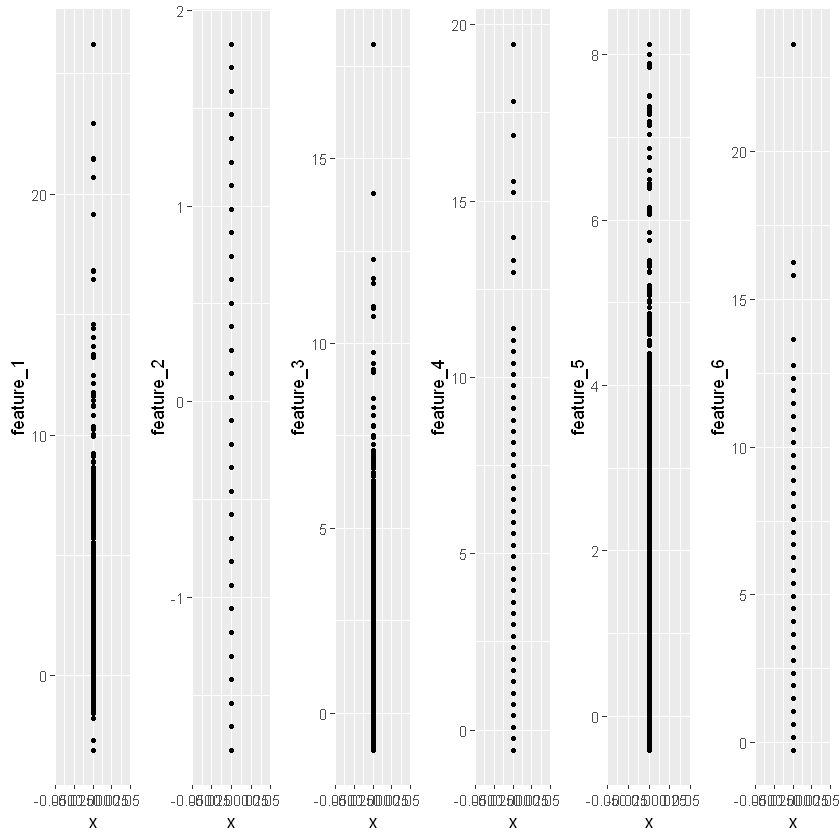

In [276]:
p0 <- ggplot(train, aes(x=0, y=feature_0)) +
  geom_point(size = 1)

p1 <- ggplot(train, aes(x=0, y=feature_1)) +
  geom_point(size = 1)

p2 <- ggplot(train, aes(x=0, y=feature_2)) +
  geom_point(size = 1)

p3 <- ggplot(train, aes(x=0, y=feature_3)) +
  geom_point(size = 1)

p4 <- ggplot(train, aes(x=0, y=feature_4)) +
  geom_point(size = 1)

p5 <- ggplot(train, aes(x=0, y=feature_5)) +
  geom_point(size = 1)

p6 <- ggplot(train, aes(x=0, y=feature_6)) +
  geom_point(size = 1)

grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 6)

Yes, it appears that feature 2, 4 and 6 are discrete, but unlikely categoric. Knowing all this, we shall proceed with the assumption that features 0-6 are conintuous numeric variables and features 7-15 are categoric. Until such time as it becomes apparent that this should change.

It's also unknown whether the integer variables are a mix of both ordinal and nominal values. For the purpose of exploration we'll keep them as integers (so we can test correlations etc.) and then we'll change any to factor if we find significant motivations to do so.

Below we change the response variable to factor in both test and train data sets.

In [8]:
#change label and features 7-15 data type to factor in train dataset
#train[,8:17] <- data.frame(lapply(train[,8:17], as.factor))
train$labels <- as.factor(train$labels)

#change label and features 7-15 data type to factor in test dataset
#test[,8:17] <- data.frame(lapply(test[,8:17], as.factor))
test$labels <- as.factor(test$labels)
                     
#always check your work - looks good.
str(train)

'data.frame':	27126 obs. of  17 variables:
 $ feature_0 : num  1.513 -1.501 0.948 -0.842 -0.559 ...
 $ feature_1 : num  -0.243 -0.213 0.581 -0.222 -0.592 ...
 $ feature_2 : num  0.143 1.225 -0.337 0.504 -1.178 ...
 $ feature_3 : num  2.019 -0.16 0.78 -0.377 -0.416 ...
 $ feature_4 : num  0.0762 -0.5694 -0.5694 0.399 -0.5694 ...
 $ feature_5 : num  -0.411 -0.411 -0.411 -0.411 -0.411 ...
 $ feature_6 : num  -0.252 -0.252 -0.252 -0.252 -0.252 ...
 $ feature_7 : int  1 8 0 9 1 4 7 6 6 9 ...
 $ feature_8 : int  1 2 2 1 2 2 1 1 1 1 ...
 $ feature_9 : int  1 1 1 1 1 2 1 2 1 3 ...
 $ feature_10: int  0 0 0 0 0 1 0 0 0 0 ...
 $ feature_11: int  1 0 0 0 1 1 0 1 1 1 ...
 $ feature_12: int  0 0 0 0 0 0 0 1 1 0 ...
 $ feature_13: int  0 0 2 0 0 0 0 2 0 0 ...
 $ feature_14: int  0 8 8 1 8 8 1 6 5 9 ...
 $ feature_15: int  3 3 3 3 3 0 3 3 3 3 ...
 $ labels    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


What proportion of the data is test versus train?

In [9]:
# get the dimentions of each dataset and return the proportion of data in the training dataset
dim(test)[1] / (dim(test)[1] + dim(train)[1])

[1] 0.2000118

The test dataset makes up one fifth of our total data

<div class="alert alert-block alert-success">

### 2.1. Univariate Analysis <a class="anchor" name="Univariate"></a>

How is the response variable distributed? Is it imbalanced? Is it biased?

Percentage rate of churn: 11.73 %

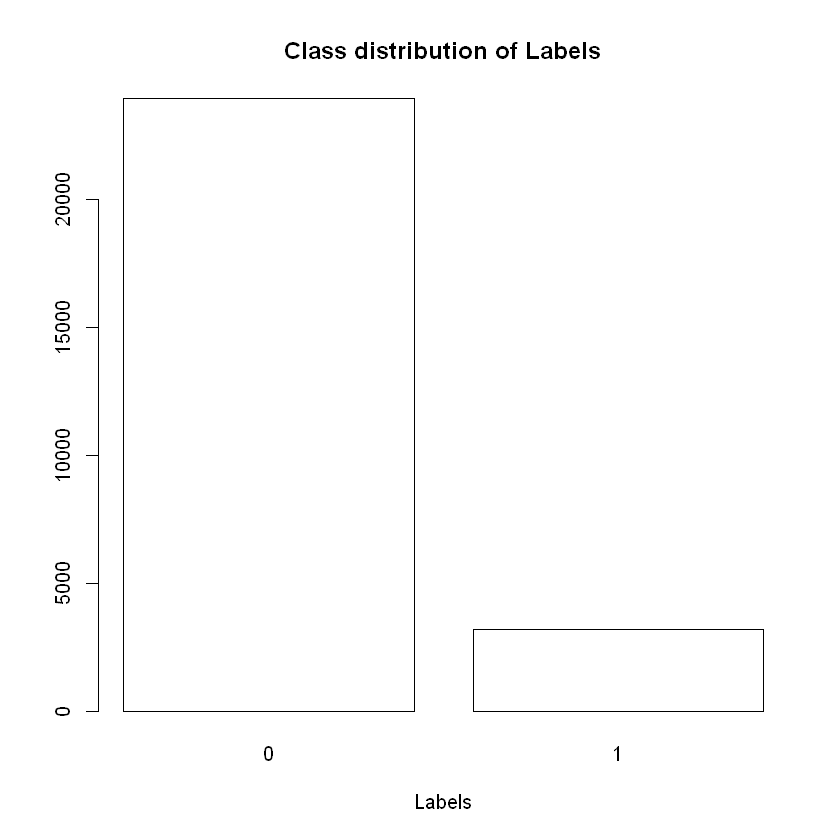

In [229]:
# produce a bar chart showing how many observations in our label data have their class equal to 1 or 0.
barplot(table(train$labels), xlab = "Labels", main = "Class distribution of Labels", col = "white")

# imbalance as a ratio
pc <- round(table(train$labels)[2] / length(train$labels) * 100, 2)
cat('Percentage rate of churn:', pc, '%')

There is no **detectable** bias in the label data, as we do not know any true information about real churn rates compared to the rates observed in this dataset. However, the class distribution in the label is very imbalanced (regardless of bias), this will likely become an issue for some learning algorithms later and will need to be factored in.



Detailed descriptive statistics for continuous data:

In [11]:
# return summary statistics for the train dataset
round(describe(train[,1:7]), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
feature_0,1,27126,-0.005,1.000,-0.182,-0.068,0.977,-2.160,5.091,7.251,0.677,0.292,0.006
feature_1,2,27126,0.001,0.986,-0.297,-0.193,0.223,-3.081,26.223,29.304,7.503,103.612,0.006
feature_2,3,27126,0.004,1.000,0.023,-0.010,1.247,-1.779,1.826,3.605,0.088,-1.058,0.006
feature_3,4,27126,-0.002,0.997,-0.307,-0.186,0.530,-1.002,18.095,19.097,3.157,18.827,0.006
feature_4,5,27126,0.000,1.009,-0.247,-0.210,0.479,-0.569,19.444,20.013,5.101,44.119,0.006
feature_5,6,27126,-0.003,0.997,-0.411,-0.285,0.000,-0.411,8.128,8.539,2.639,7.088,0.006
feature_6,7,27126,-0.009,0.795,-0.252,-0.197,0.000,-0.252,23.626,23.878,7.360,96.290,0.005


Some initital findings from summary statistics:
- **Missing Data:** There is no missing data in any features
- **Mean:** The data all appear to have relatively similar means, ranging between values of -1 and 6
- **Median:** The range of median values is slightly wider than the mean, but not by much.
- **Standard Deviation / Error:** Once standardised (using standard error), this data all has very similar spread.
- **Range:** The range of values in all the data only spread from (approximately) -2 to 24. Feature 1 has the widest range of all, next to 3, 4 and 6.
- **Skew:** Feature 1 & 6 have highest skew, in the positive direction.
- **Range:** Features 1 & 6 have the widest range.
- **Kurtosis:** Features 1, 4 & 6 have relatively high kurtosis, making their tails very short. Conversely, quite a few variables have longer tails, measuring no lesser than -1.06 though.
- **Scaling:** there has been no feature scaling yet (e.g. min-max scaling), we may need to do this for some types of statistical model
- **Expected Data Characteristics:** Given that we don't have any particular knowledge about each feature, we cannot comment on the expected or unexpected characteristics of each variable. Only that our response variable has two classes, 0 and 1 which represent churn and no churn as expected.

Descriptive statistics for discrete data:

In [282]:
summary(data.frame(lapply(test[,8:17], as.factor)), maxsum = 12)

 feature_7 feature_8 feature_9 feature_10 feature_11 feature_12 feature_13
 0 : 806   0: 788    0:1014    0:6652     0:2925     0:5680     0:4361    
 1 :1432   1:4021    1:3527    1: 130     1:3857     1:1102     1: 428    
 2 : 220   2:1973    2:1946                                     2:1993    
 3 : 182             3: 295                                               
 4 :1408                                                                  
 5 : 354                                                                  
 6 : 225                                                                  
 7 : 640                                                                  
 8 : 135                                                                  
 9 :1160                                                                  
 10: 179                                                                  
 11:  41                                                                  
 feature_14 feature_15 la

Qualitative data ranges from 2 to 12 categories. None are evenly distributed, while many have a clear preference towards one class over the others, such as feature_13 which has 17,617 in class '0' and less than 10,000 observations in the other two classes ('1' & '2') combined.

Histograms and Density Plots for our continuous data:

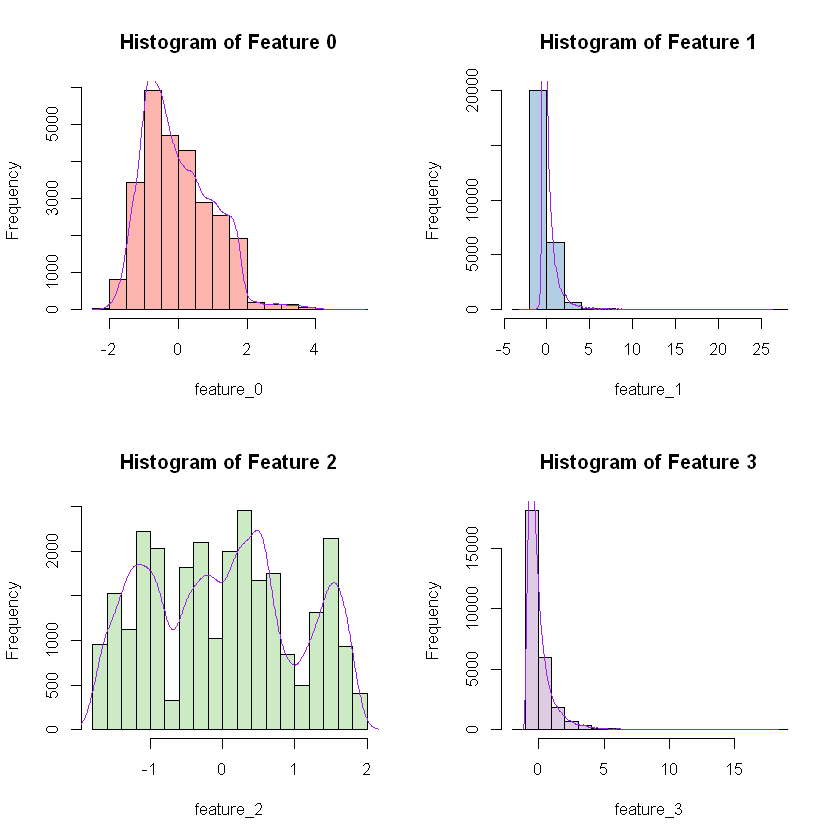

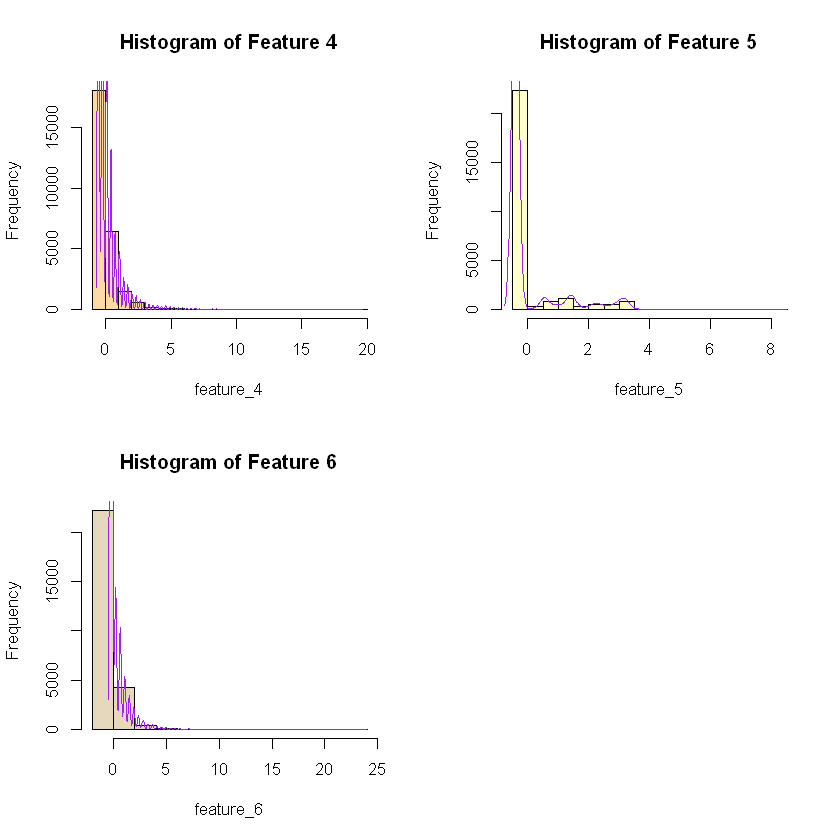

In [283]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

# Histogram for features 0 to 6
par(mfrow = c(2,2))
for (i in 1:7 ) {
    h <- hist(train[,i], plot=FALSE)
    plot(h, main=paste("Histogram of Feature", i-1), xlab = names(train[i]), col = brewer.pal(8, name = "Pastel1")[i])
    d <- density(train[,i])
    lines(x = d$x, y = d$y * length(train[,i]) * diff(h$breaks)[1], col = "purple", lwd = 1.5)
}

The histograms seem to tell us that the data here is a mix of left skewed (0), exponential (1, 3, 4 & 6) and uniformly (2?) distributed features are seen here. But the density plots say a whole lot more. Most of our exponential data is just very highly right skewed unimodal. Our questionably uniform feature (2) could alternatively be multimodal.  There are also some interesting artefacts on features 4 & 6, some kind of decaying harmonic oscillation. Feature 5 appears to have some kind of normal distribution with a right tail, could be right skewed unimodel, or it could be something else, it might help to take a closer look.

Below we use log scaling to look more closely at the tail end of the data in feature 5.

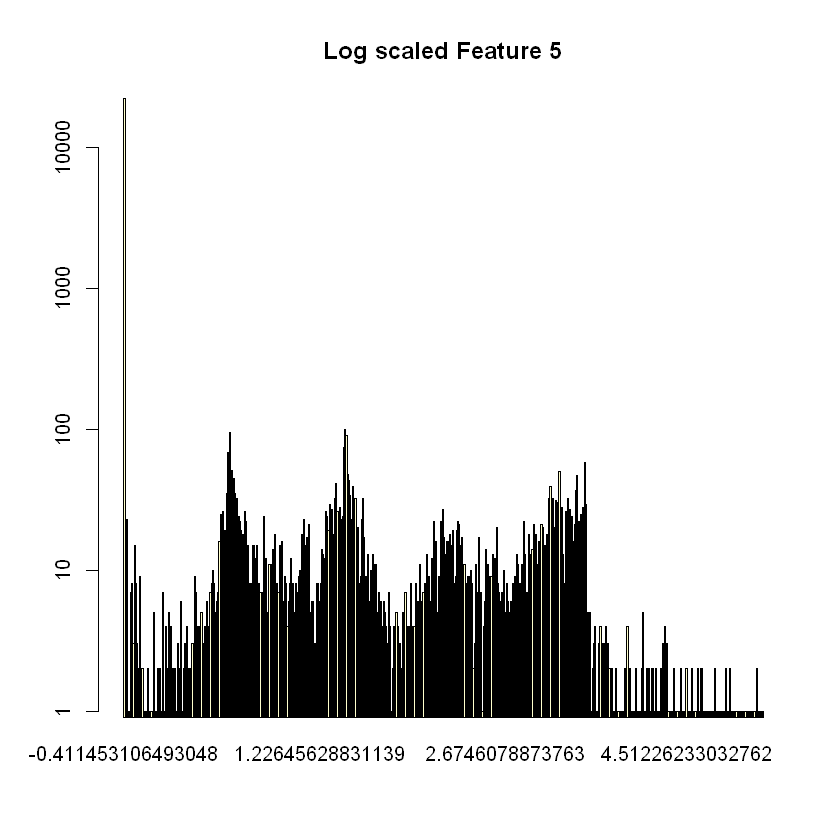

In [14]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=2) 
#par(mfrow = c(1,2))

barplot(table(train[,6]), log="y", xlab = names(train[,6]), main = paste("Log scaled Feature", 5), col = brewer.pal(8, name = "Pastel1")[6])

This is definately not the best chart option for the job, but it does have an in-built log scale. It shows that the data could be multimodal.

It could be improved with binning:

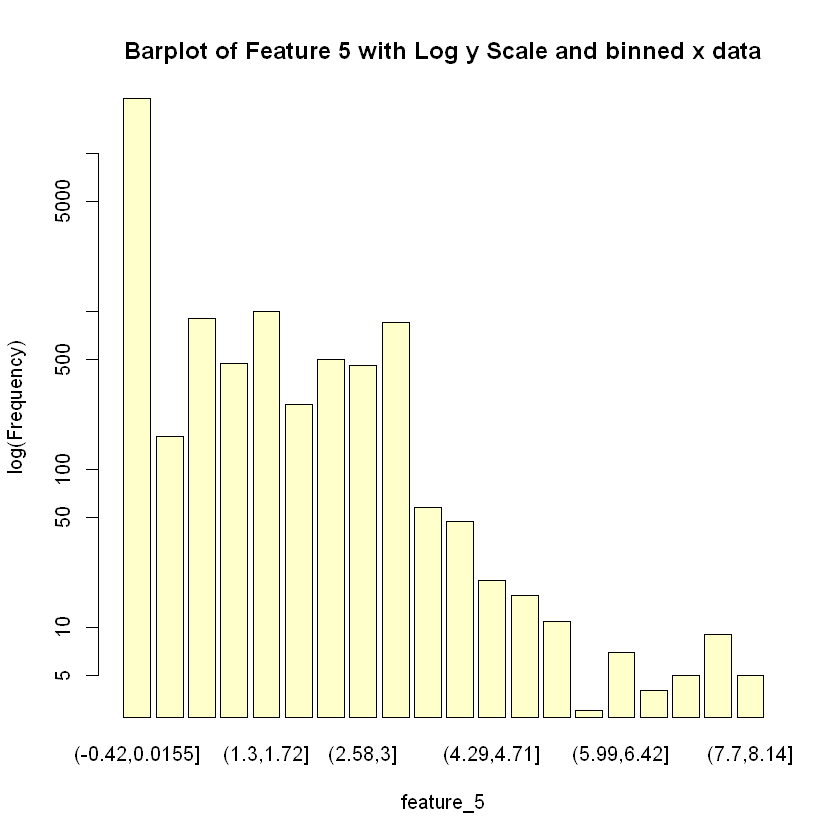

In [15]:
barplot(table(bin(train[,6], nbins = 20)), log = "y", xlab = "feature_5", ylab = "log(Frequency)", main = "Barplot of Feature 5 with Log y Scale and binned x data", col = brewer.pal(8, name = "Pastel1")[6])

This is quite unusual, not an easily identifiable distribution.

Moving on. Bar chart exploration for our (assumed) qualitative data:

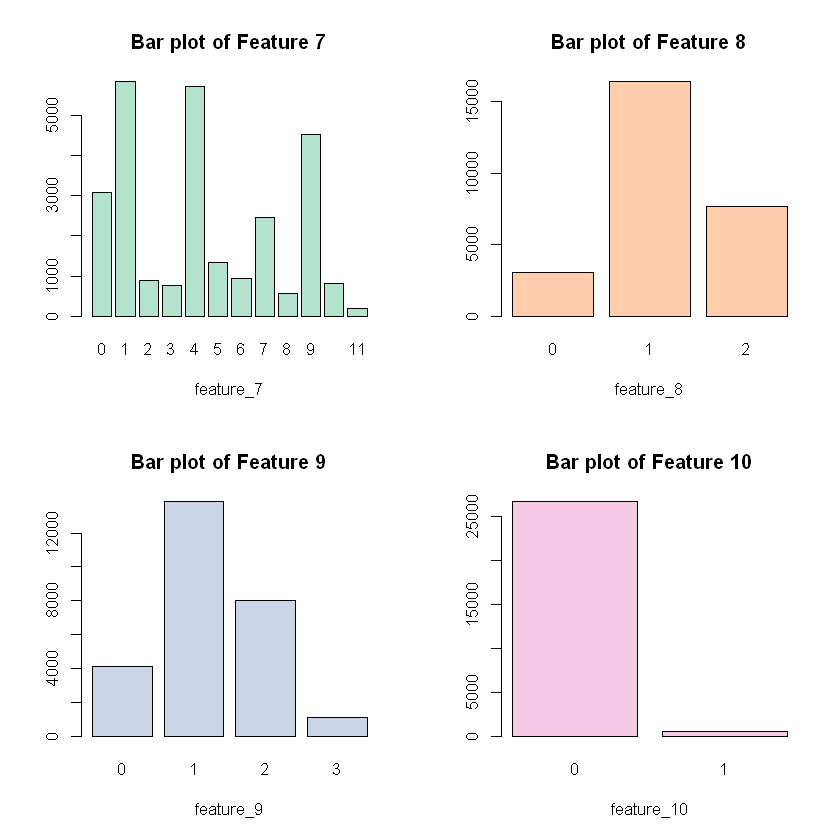

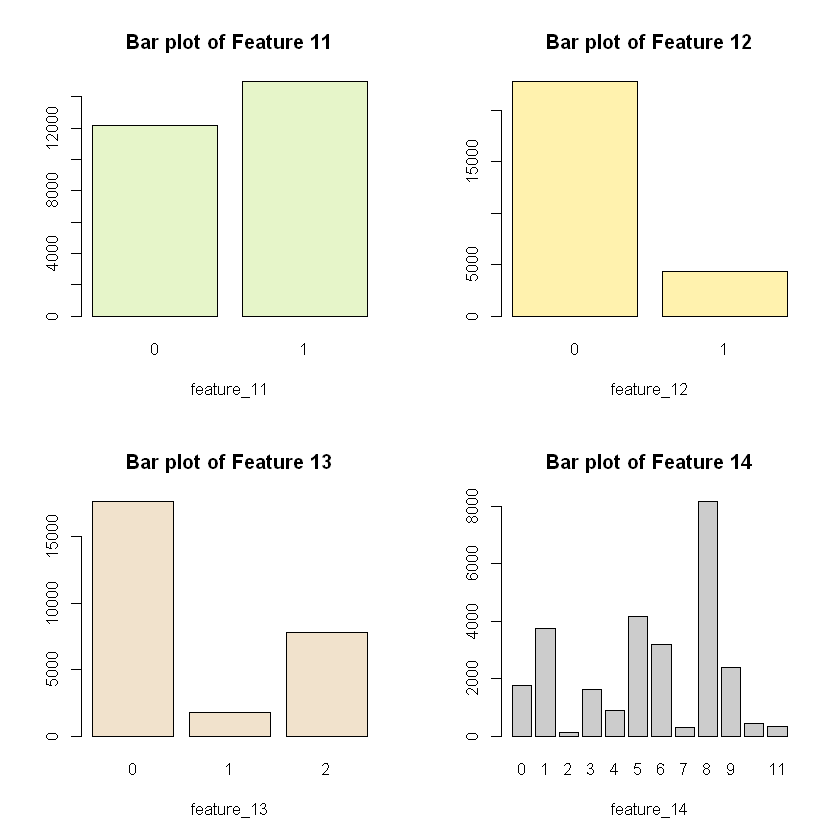

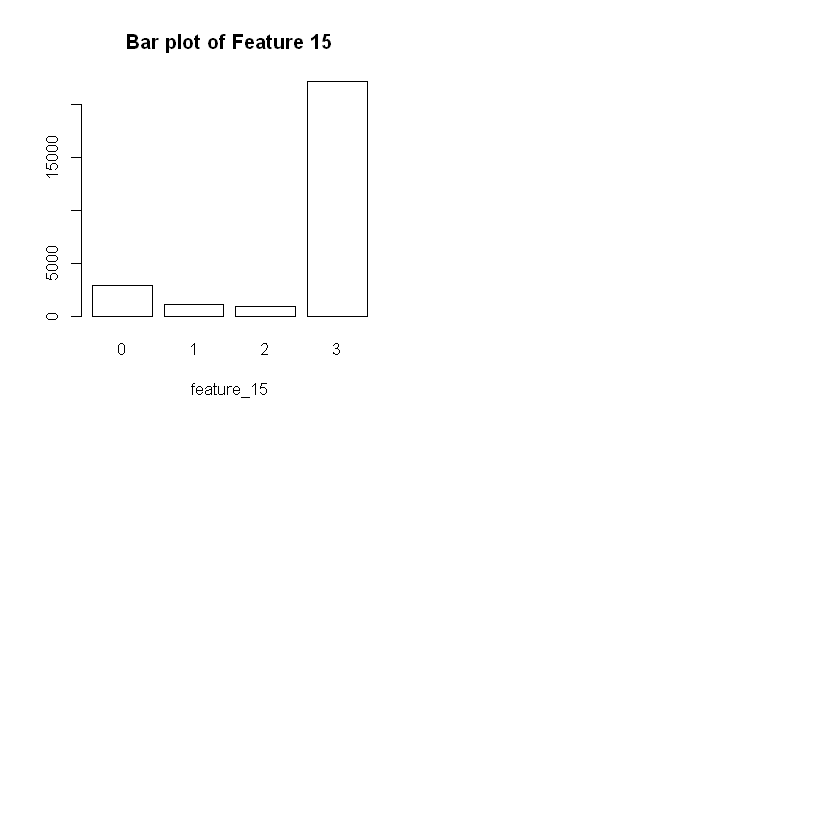

In [16]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1)


# Bar chart for features 7 to 15
par(mfrow = c(2,2))
for (i in 8:16 ) {
        barplot(table(train[,i]), xlab = names(train[i]), main = paste("Bar plot of Feature", i-1), col = brewer.pal(8, name = "Pastel2")[i-7])
}

As found earlier, features 10, 11, 12 and the label are binomial. Features 10 & 12 are primarliy distributed at zero. Feature 11 on the otherhand is a little more evenly distributed.

The rest of our features are multinomial with little patterning to them.

<div class="alert alert-block alert-success">

### 2.2. Summary of Univariate Analysis <a class="anchor" name="SumUnivariate"></a>

### Quantitative vs Qualitative Variables:

There is a wide variety of data present with continuous variables, discrete numeric variables as well as integer sets that could easily represent categoric information. For the purpose of exploration, we have decided to proceed as if features 0 - 6 are continuous while 7 to 15 are categoric. As we have no context for this data, we cannot deduce easily whether the integer variables are ordinal (logically ordered or ranked) or nominal (have no logical sequence). It is possible that their relationships with other variables could reveal the possibility of a rank or logical order. This information is important to determine whether dummy encoding is needed for specific learning algorithms later on.

### Distributions:
Other notable observations incluide that feature 0, 1, 3, 4 & 6 are all skewed (although the histogram would have you beleive otherwise). Feature 5 looks interesting, it could be skewed, exponential or something else entirely. Meanwhile feature 2 is fairly uniformly distributed (possibly 7 and 11 too). Many of the integer features (7 and above) show a clear imbalance where one class is prefenced (particularly 10, 12 and 15). Features 8 and 9 show some degree of normal distribution however, since it is discrete this is probably not the case. It's hard to determine what information 7 & 14 have to give from this, they are discrete with no clear distribution meaning that they could be nominal variables with no clear rank or order, these would be prime candidates for tree methods or dummy encoding for other learning methods.

### Labels class imbalance
The response variable is not evenly distributed. The majority class (0) is very dominant here and so we expect that learning algorithms will significantly favour this class for positive prediction unless we compensate. Resampling or shifting probability thresholds may be necessary so as not to introduce bias in our learning/modelling algorithms.

### Other notes
Feature scaling has not been completed on this dataset. Some algorithms might need us to preform this. There is no missing data in any features. Given that we don't have any particular knowledge about each feature, we cannot comment more generally on the expected or unexpected characteristics of each variable, such as the range of values and outliers.
_________________________

<div class="alert alert-block alert-success">

### 2.3. Bivariate Analysis <a class="anchor" name="Bivariate"></a>

Checking for highly colinear features.

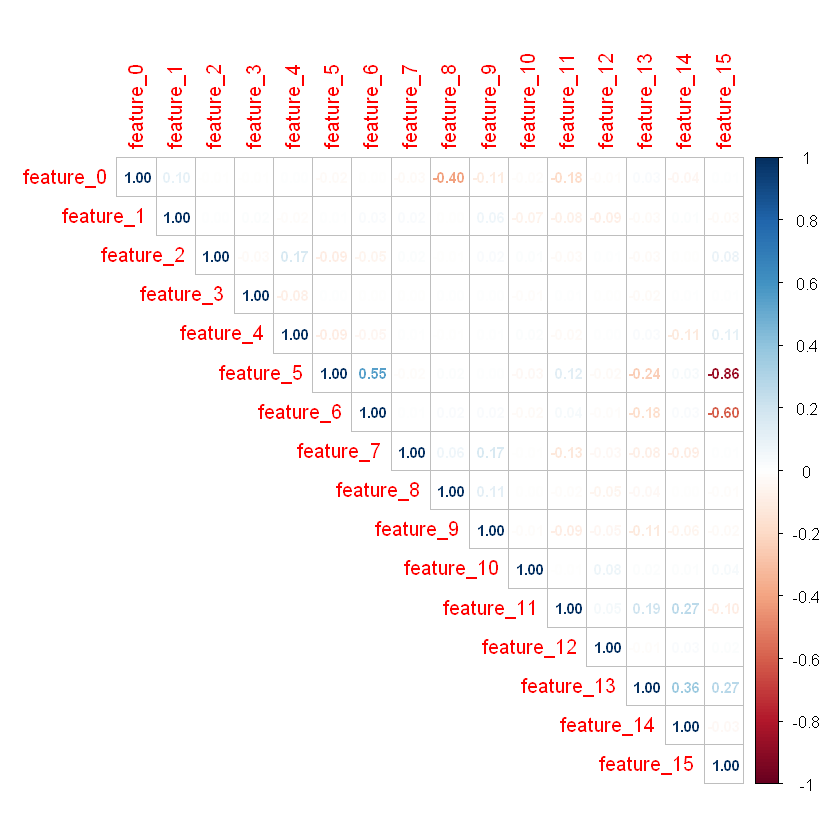

In [17]:
# exclude our label from correlation data since it is a factor
cor <- cor(train[-17])

# plot correlations
corrplot(cor, method = 'number', type = 'upper',number.cex=0.75)

Feature 15 and 5 are highly correlated, 15 and 6 are somewhat similar too, it's possible these pairs carry the same information. We should remove feature 15 or 5 & 6. We will need to look at how each of these relate to our label before deciding which to remove.

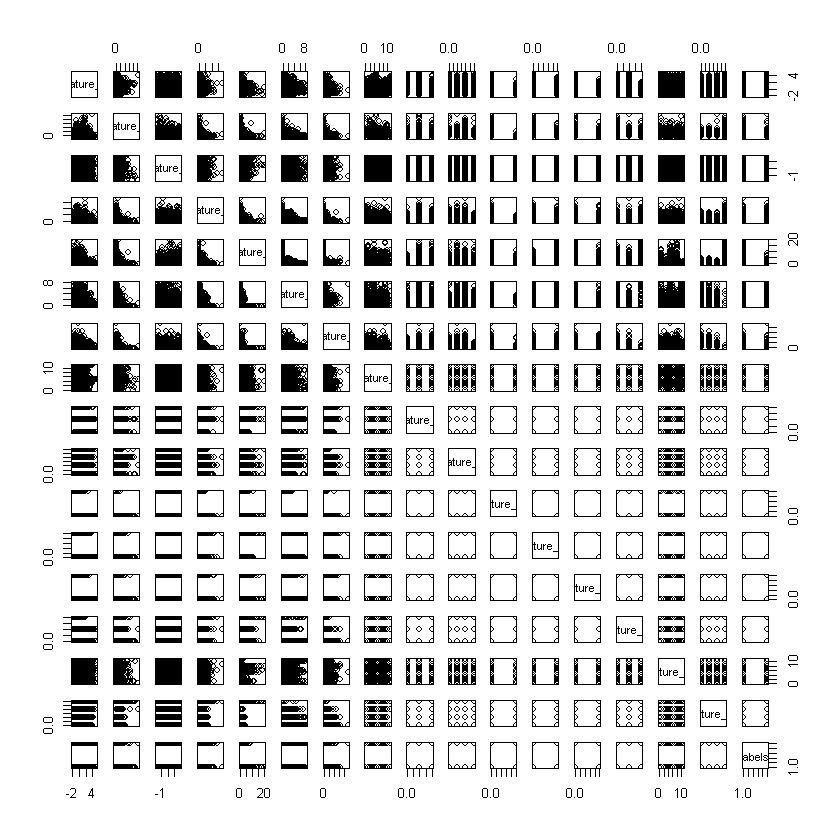

In [39]:
pairs(train)

In [286]:
cor(train[,-17], as.numeric(train[,17])) 

feature_0,0.01550229
feature_1,0.05064085
feature_2,-0.02975611
feature_3,0.39008974
feature_4,-0.07615220
feature_5,0.11057683
feature_6,0.11904202
feature_7,0.03671097
feature_8,0.04254066
feature_9,0.06883864
feature_10,-0.02411465


It appears that feature 3 (cor = 0.39) could be an important predictor.

### Comparing continuous variables against the categoric label:

Side by side box plots are ideal for comparing the continuous variables against categories in the response variable (labels). Many outliers have been deliberately removed with boxplots rescaled, as it was difficult to see the main quantiles of the distributions.

Warning message:
"Removed 4955 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2705 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2602 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 2691 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1314 rows containing non-finite values (stat_boxplot)."

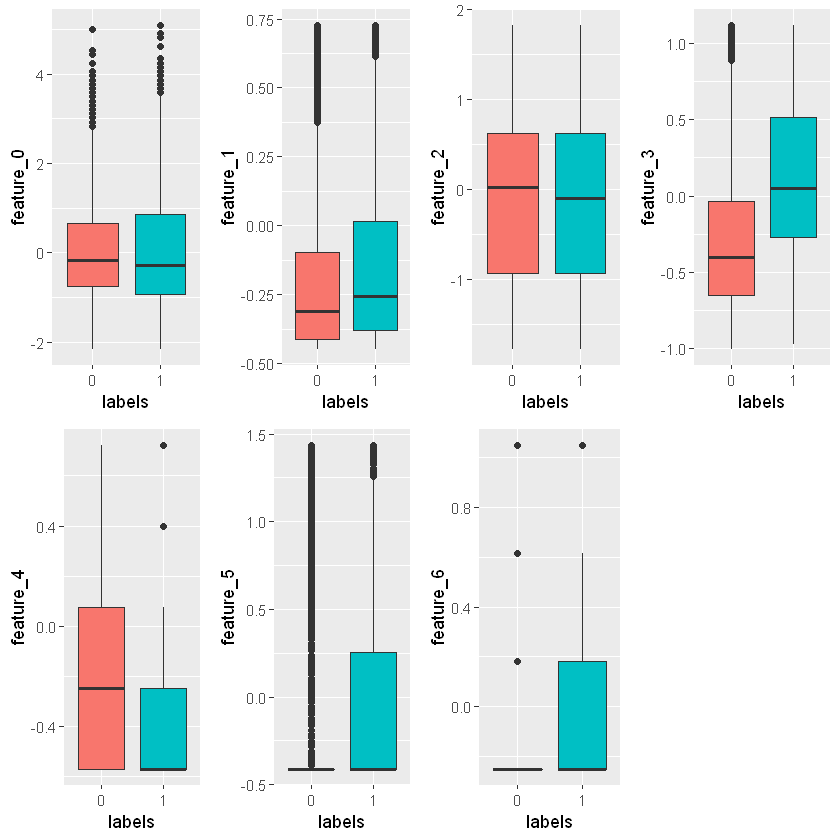

In [18]:
p1 <- ggplot(train, aes(x=factor(labels), y=train[,1], fill=factor(labels))) + 
          geom_boxplot()+
          #scale_y_continuous(limits = c(quantile(train[,1], c(0.1, 0.9))[1], quantile(train[,1], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[1]) +
          guides(fill="none")

p2 <- ggplot(train, aes(x=factor(labels), y=train[,2], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,2],c(0.1, 0.9))[1], quantile(train[,2], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[2]) +
          guides(fill="none")

p3 <- ggplot(train, aes(x=factor(labels), y=train[,3], fill=factor(labels))) + 
          geom_boxplot()+
          #scale_y_continuous(limits = c(quantile(train[,3], c(0.1, 0.9))[1], quantile(train[,3], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[3]) +
          guides(fill="none")

p4 <- ggplot(train, aes(x=factor(labels), y=train[,4], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,4], c(0, 0.9))[1], quantile(train[,4], c(0, 0.9))[2]))+
          labs(x = "labels",y = names(train)[4]) +
          guides(fill="none")

p5 <- ggplot(train, aes(x=factor(labels), y=train[,5], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,5], c(0, 0.9))[1], quantile(train[,5], c(0, 0.9))[2]))+
          labs(x = "labels",y = names(train)[5]) +
          guides(fill="none")

p6 <- ggplot(train, aes(x=factor(labels), y=train[,6], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,6], c(0.1, 0.9))[1], quantile(train[,6], c(0.1, 0.9))[2]))+
          labs(x = "labels",y = names(train)[6]) +
          guides(fill="none")

p7 <- ggplot(train, aes(x=factor(labels), y=train[,7], fill=factor(labels))) + 
          geom_boxplot()+
          scale_y_continuous(limits = c(quantile(train[,7], c(0, 0.95))[1], quantile(train[,7], c(0, 0.95))[2]))+
          labs(x = "labels",y = names(train)[7]) +
          guides(fill="none")


grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol = 4)

These box plots reveal that features 1 & 3 exhibit higher mean for churn (1) compared to no churn (0). Feature 0 has a wider distribution for churn than no churn. Feature 2 has a slightly lower mean for churn but the same overall spread. feature 5 & 6 appear to be very similar, with the same mean but greater spread for churn. Lastly, feature 4 has lower mean and spread for churn. These are explored in increased detail below with density plots.

# DELETE THIS ONE...?

Warning message:
"Removed 619 rows containing non-finite values (stat_density)."Warning message:
"Removed 726 rows containing non-finite values (stat_density)."Warning message:
"Removed 111 rows containing non-finite values (stat_density)."Warning message:
"Removed 447 rows containing non-finite values (stat_density)."

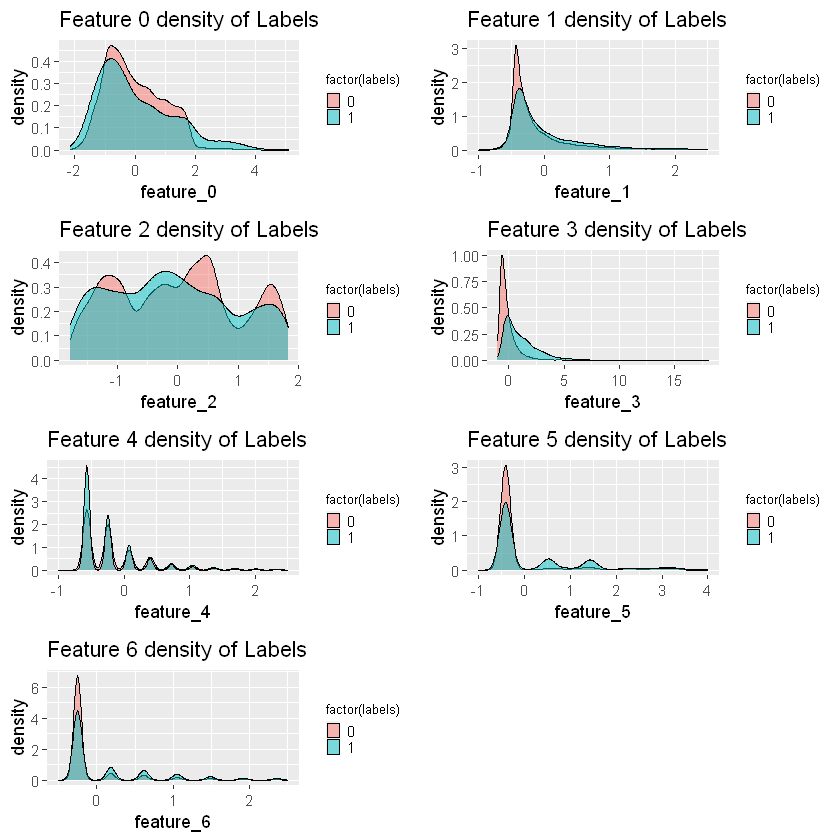

In [19]:
p1 <- ggplot(train) +
  geom_density(aes(x = feature_0, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_0') +
  ggtitle("Feature 0 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p2 <- ggplot(train) +
  geom_density(aes(x = feature_1, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_1') +
  ggtitle("Feature 1 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,2.5))

p3 <- ggplot(train) +
  geom_density(aes(x = feature_2, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_2') +
  ggtitle("Feature 2 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p4 <- ggplot(train) +
  geom_density(aes(x = feature_3, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_3') +
  ggtitle("Feature 3 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))

p5 <- ggplot(train) +
  geom_density(aes(x = feature_4, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_4') +
  ggtitle("Feature 4 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,2.5))

p6 <- ggplot(train) +
  geom_density(aes(x = feature_5, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_5') +
  ggtitle("Feature 5 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-1,4))

p7 <- ggplot(train) +
  geom_density(aes(x = feature_6, fill = factor(labels)), alpha=.5) +
  labs(x = 'feature_6') +
  ggtitle("Feature 6 density of Labels")+
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8)) +
  xlim(c(-0.5,2.5))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol = 2)

Label class compartisons for features 2 appeared quite similar in their box plots, however there are distinct differences in their density plots above which may assist modelling, a closer look at interactions between it and other variables could be helpful. We see again here that features 5 & 6 are very similar. The difference in mean and spread of 1 & 3 remains convincing.

### Comparing two categoric variables
Bar charts are used to compare features 7-15 against their labels. Since there is substantial imbalance between the churn and no churn rates, we use a percentage scale for comparisons.

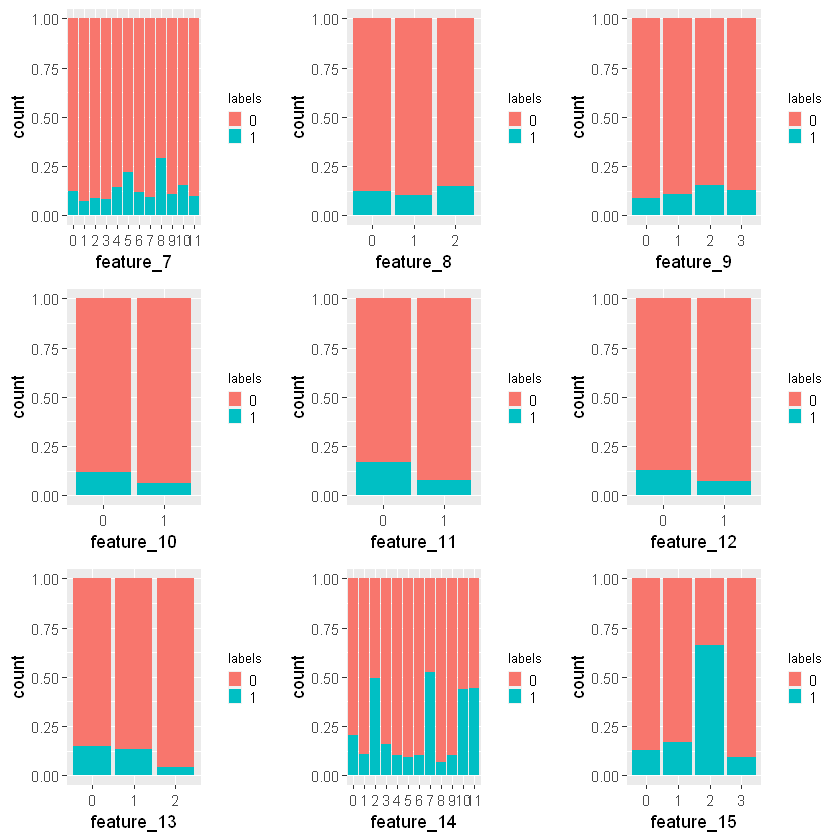

In [211]:
p7<- ggplot(train, aes(x = factor(feature_7), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_7')

p8<- ggplot(train, aes(x = factor(feature_8), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_8')

p9<- ggplot(train, aes(x = factor(feature_9), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_9')

p10<- ggplot(train, aes(x = factor(feature_10), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_10')

p11<- ggplot(train, aes(x = factor(feature_11), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_11')

p12<- ggplot(train, aes(x = factor(feature_12), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_12')

p13<- ggplot(train, aes(x = factor(feature_13), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_13')

p14<- ggplot(train, aes(x = factor(feature_14), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_14')

p15<- ggplot(train, aes(x = factor(feature_15), fill = labels)) + 
  geom_bar(position = "fill") +
  theme(legend.key.size = unit(0.3, 'cm'), legend.title = element_text(size=8))+
  xlab('feature_15')


grid.arrange(p7, p8, p9, p10, p11, p12, p13, p14, p15, ncol = 3)

The overall imbalance in this datasets labels dictates that churn (1/blue) should be roughly around 12%. We see substantial deviation from this for some category values in feature 7, 14 and 15. These could be helpful in predicting churn.

<div class="alert alert-block alert-success">

### 2.4. Summary of Bivariate Analysis <a class="anchor" name="SumBivariate"></a>

In this section correlation is measured between features to identify issues relating to covariance.

Correlation against the label is used to identify that feature 3 will be an important predictor for any linear models.

Boxplots of the continuous variables broken down by label confirm that 3 has a lot of promise as a predictor. Additionally feature 1 may be of importance.

Bar charts show that features 7, 14, 15 have distributions that deviate from the expected 12% churn rate for some particular categories.

<div class="alert alert-block alert-success">

### 2.5. Multivariate Analysis <a class="anchor" name="Multivariate"></a>

Analysing interactions between two continuous variables:

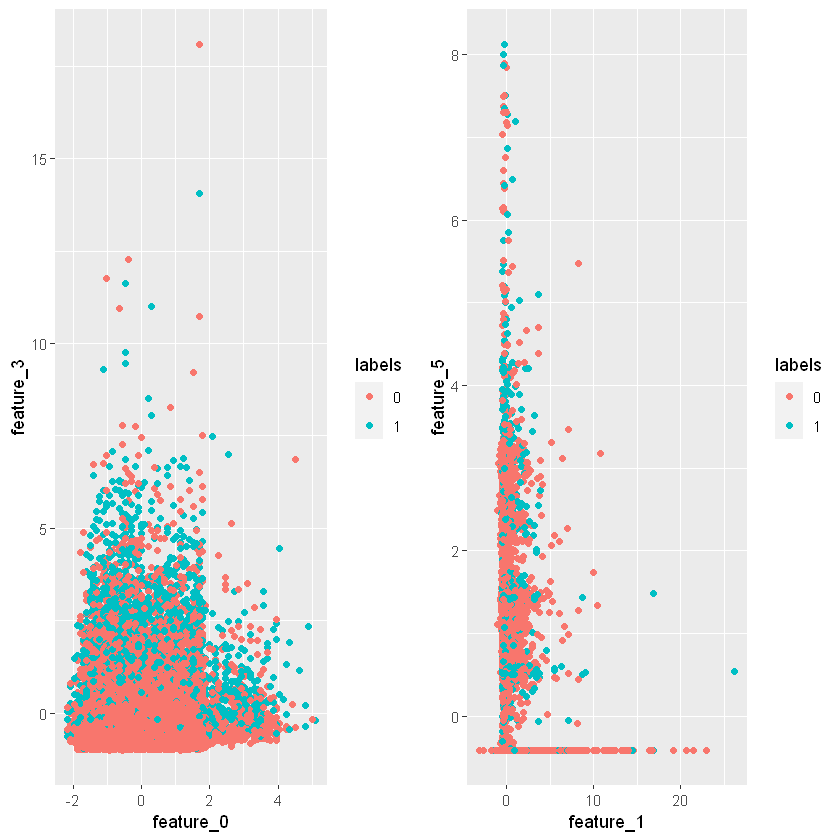

In [247]:
p1 <- ggplot(train, aes(x=feature_1, y=feature_3)) +
        geom_point(aes(colour = labels))

p2 <- ggplot(train, aes(x=feature_1, y=feature_5)) +
        geom_point(aes(colour = labels))

p1 <- ggplot(train, aes(x=feature_0, y=feature_3)) +
        geom_point(aes(colour = labels))

grid.arrange(p1, p2, ncol = 2)

Analysing interactions between continuous and discrete variables:

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

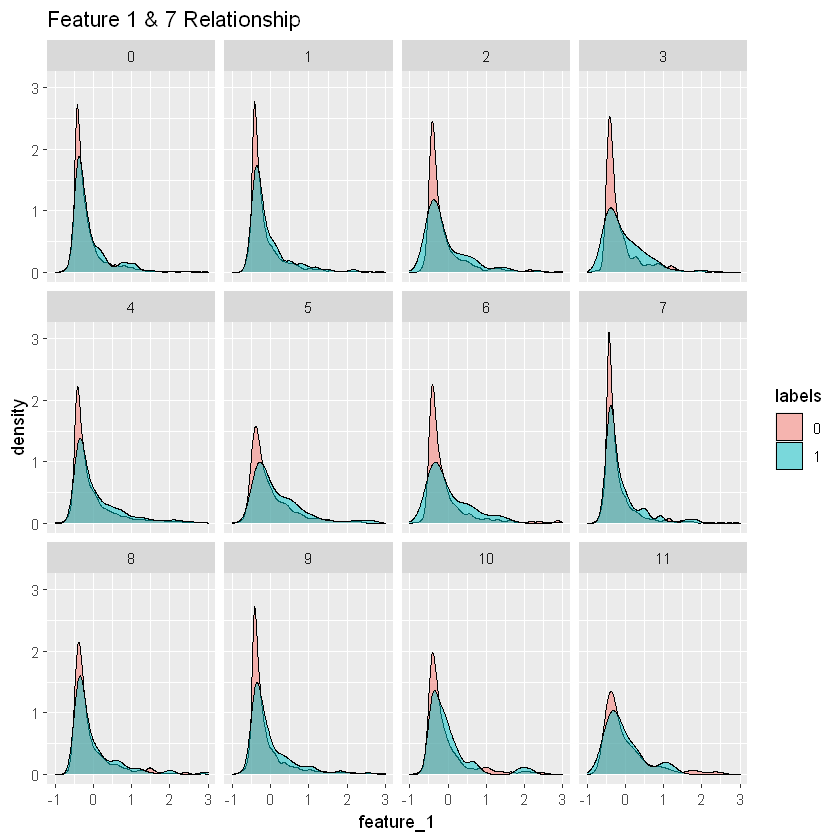

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

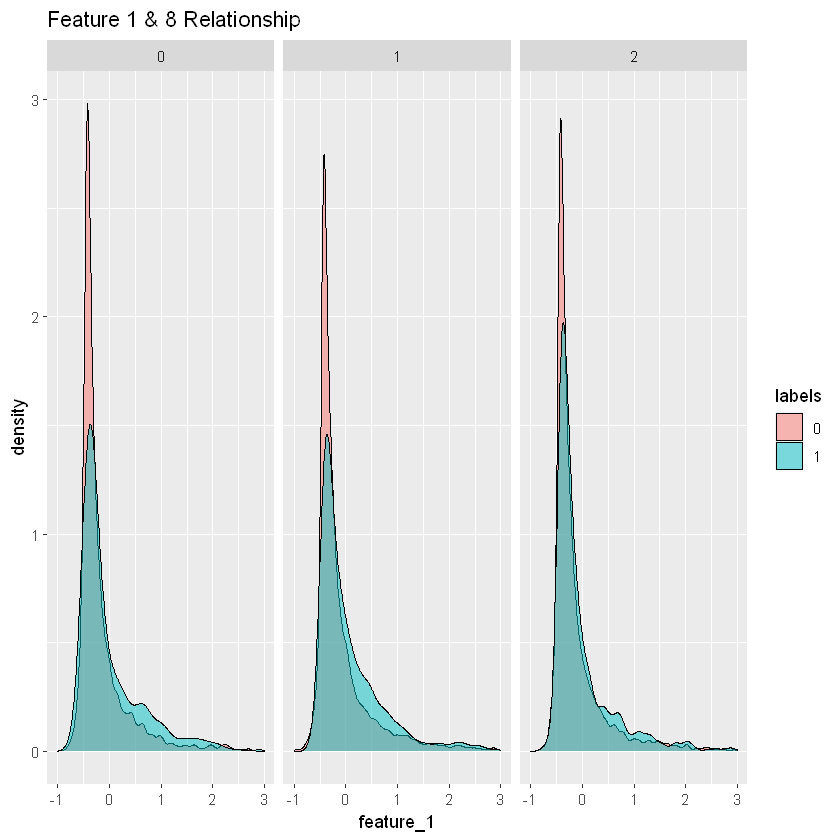

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

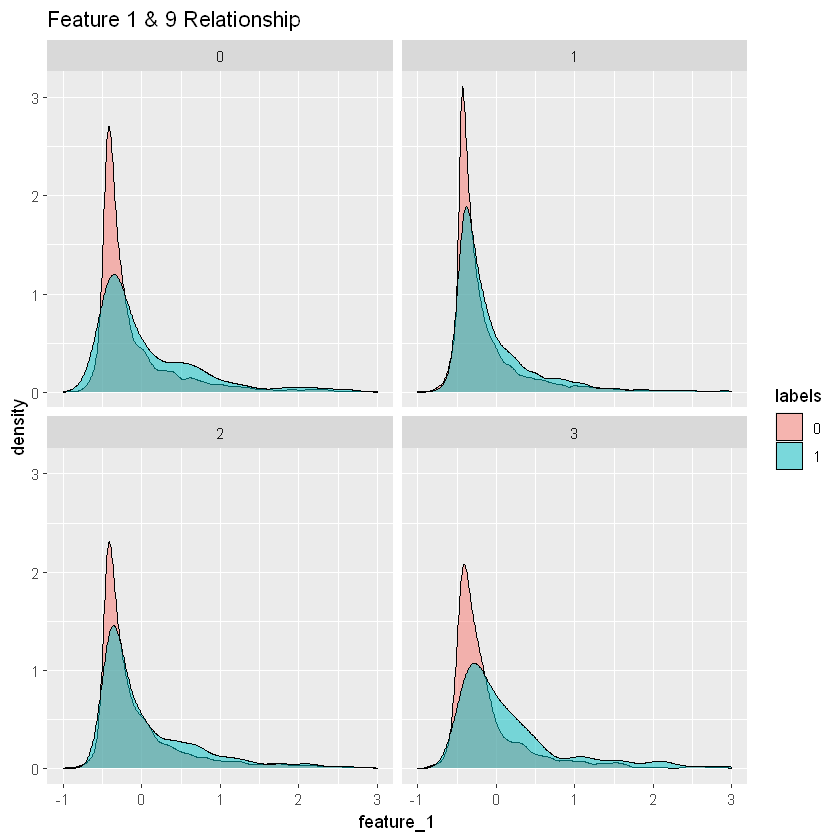

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

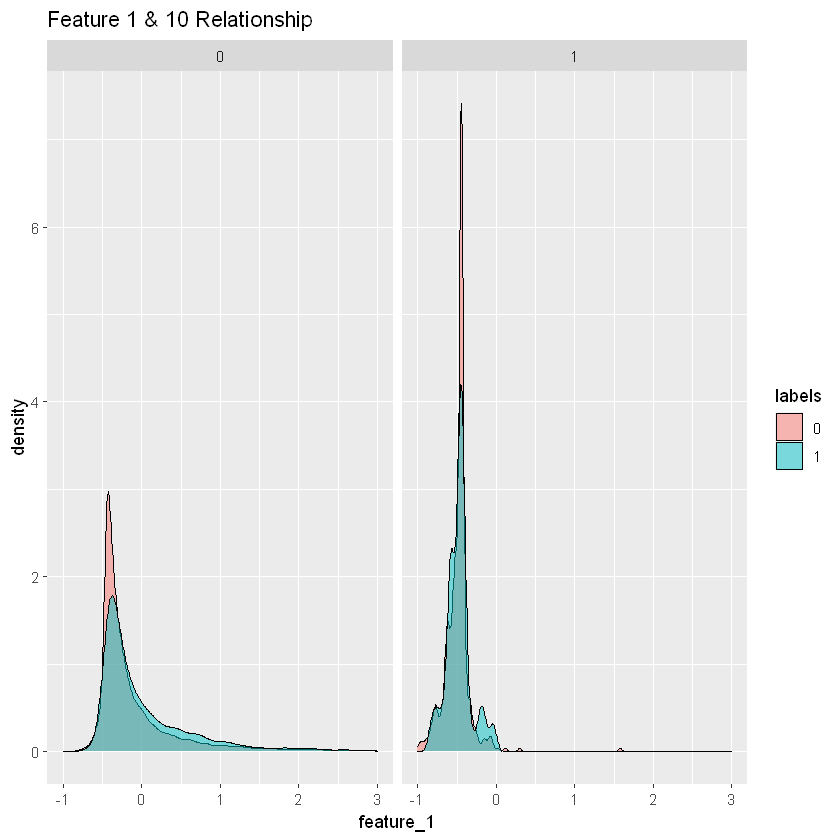

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

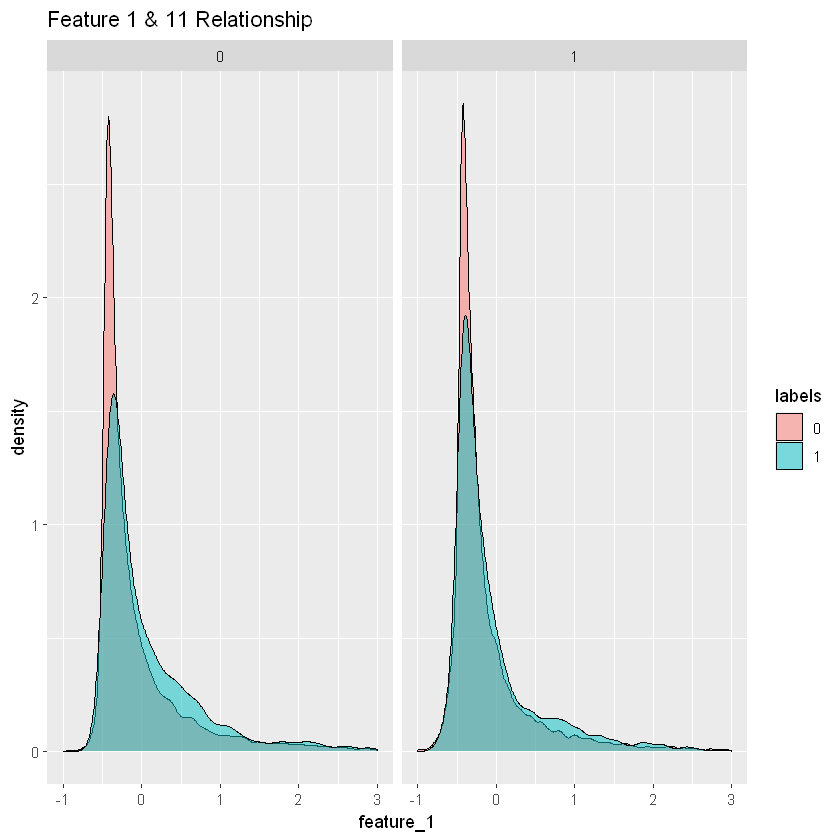

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

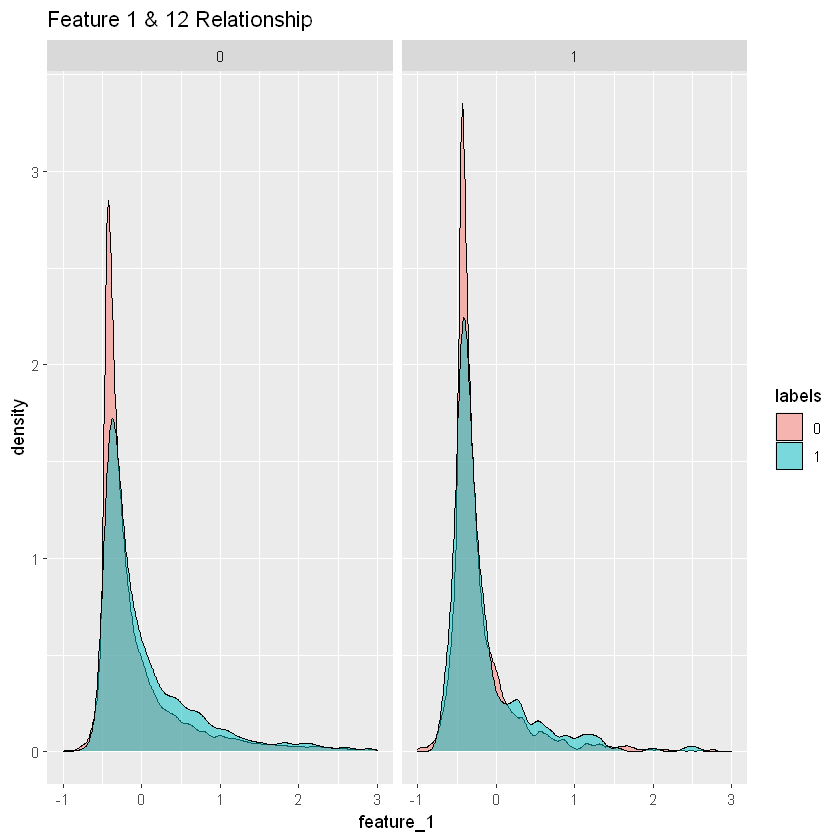

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

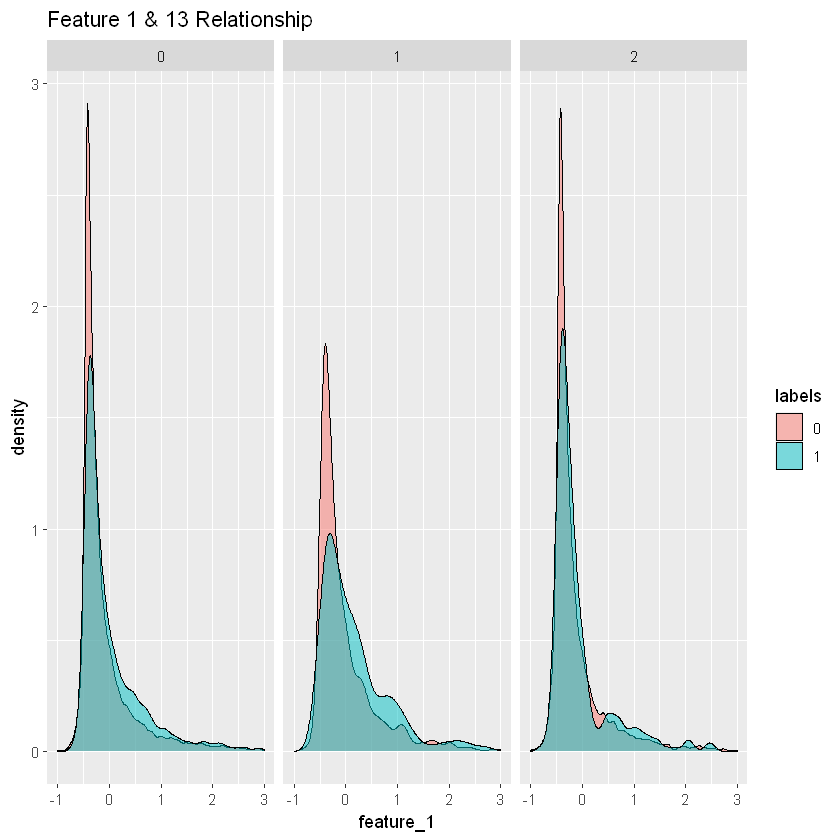

Warning message:
"Removed 462 rows containing non-finite values (stat_density)."

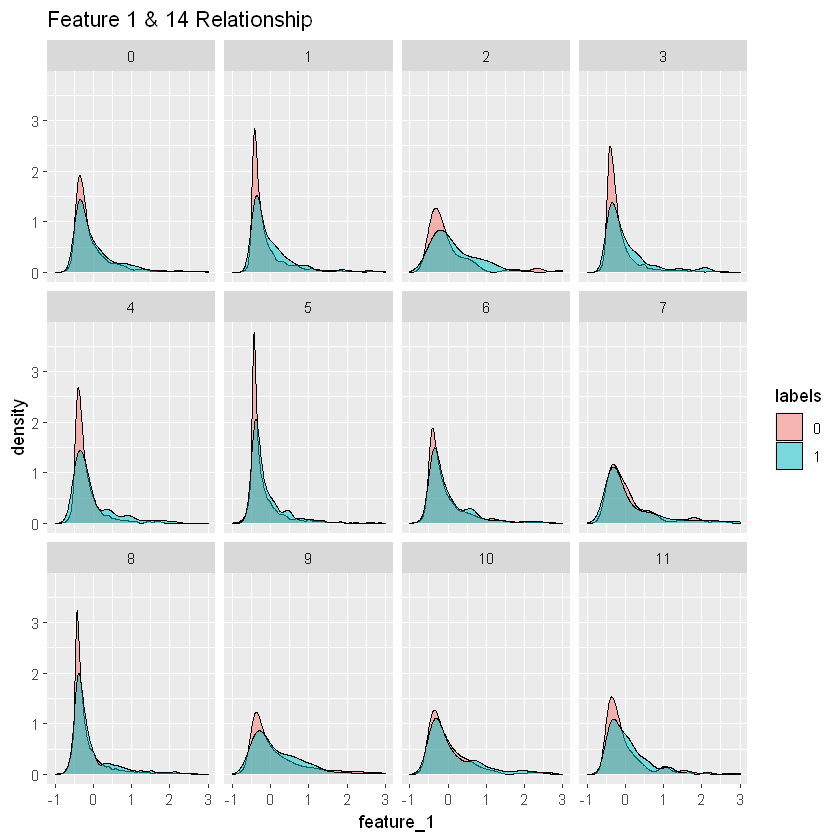

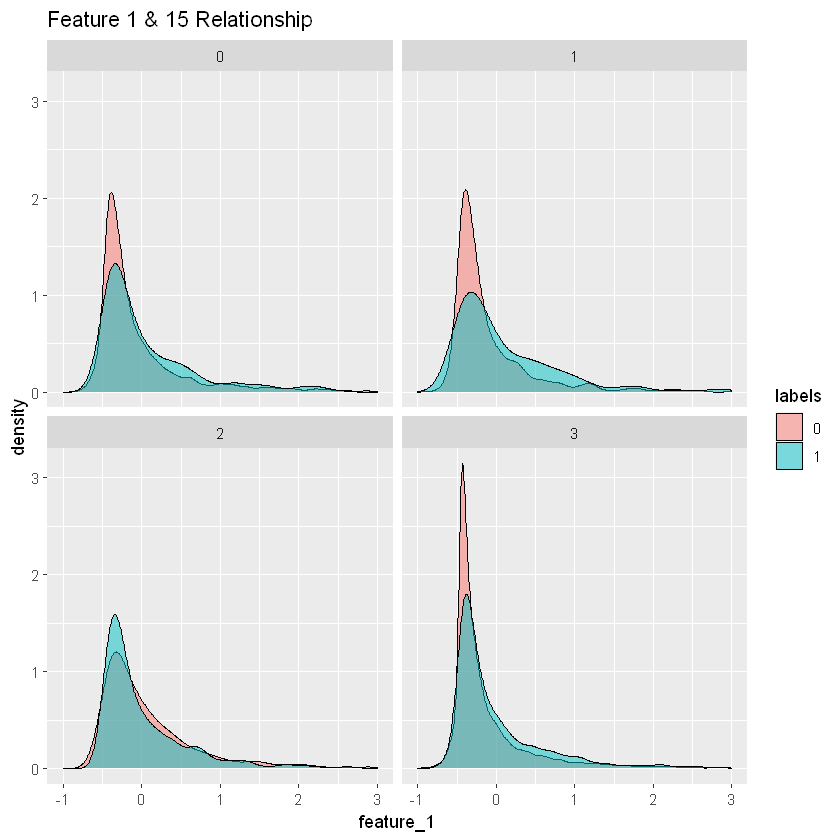

In [202]:
ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_7) +
    ggtitle('Feature 1 & 7 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_8) +
    ggtitle('Feature 1 & 8 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_9) +
    ggtitle('Feature 1 & 9 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_10) +
    ggtitle('Feature 1 & 10 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 1 & 11 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_12) +
    ggtitle('Feature 1 & 12 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_13) +
    ggtitle('Feature 1 & 13 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_14) +
    ggtitle('Feature 1 & 14 Relationship')+
    xlim(-1,3)

ggplot(aes(x=feature_1),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_15) +
    ggtitle('Feature 1 & 15 Relationship')+
    xlim(-1,3)

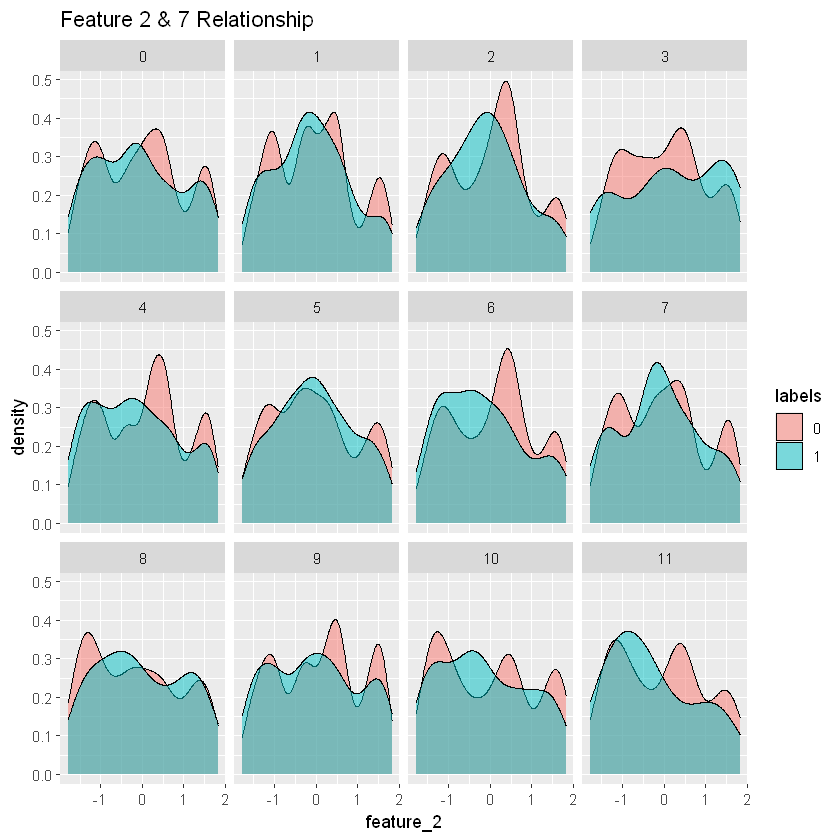

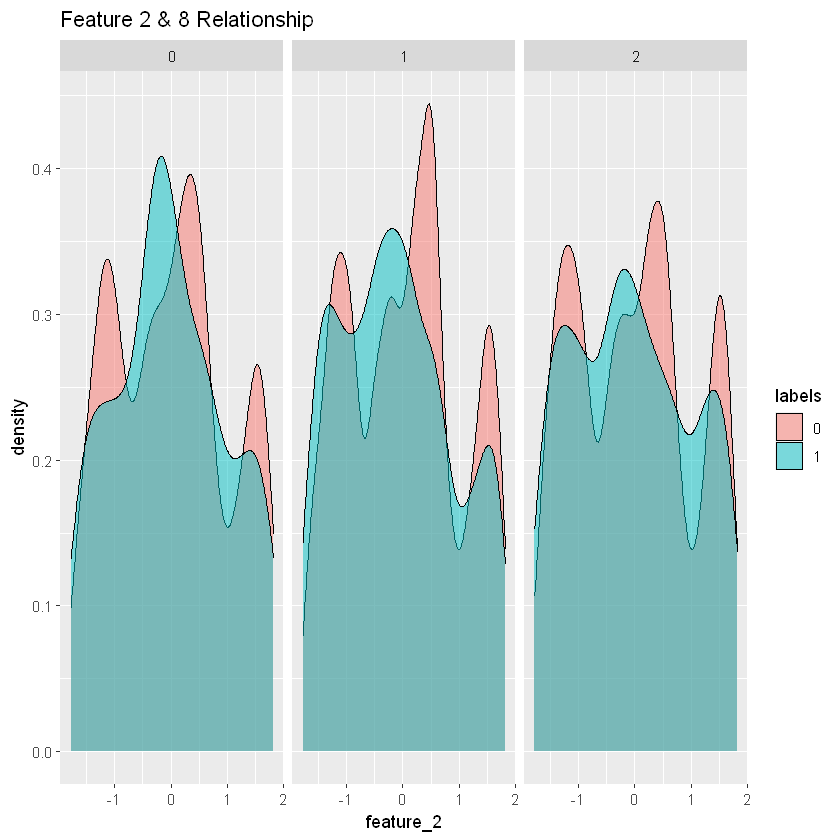

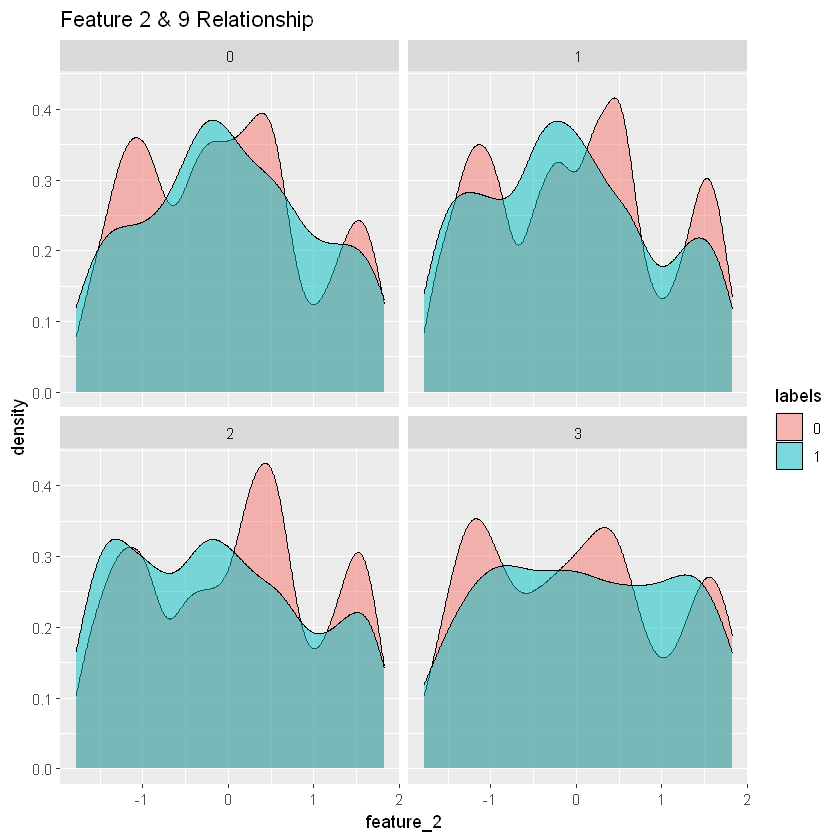

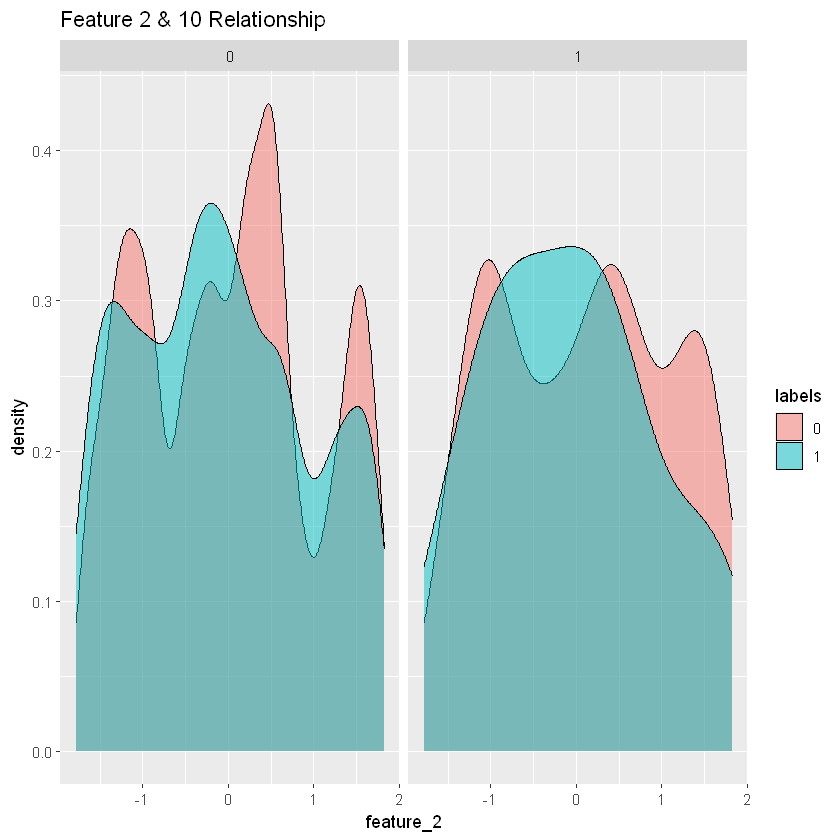

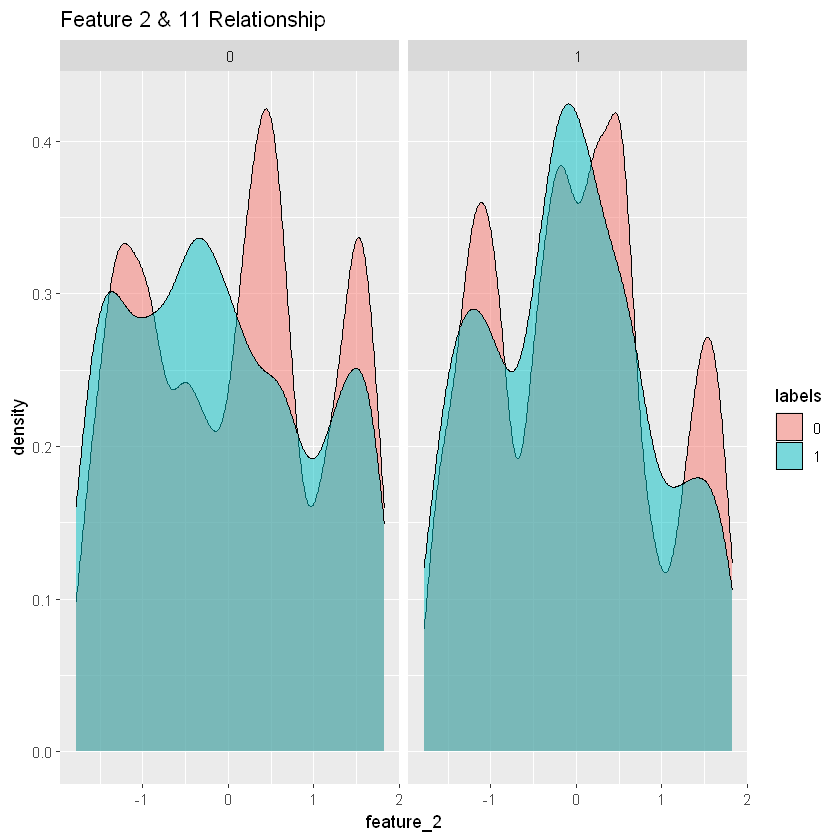

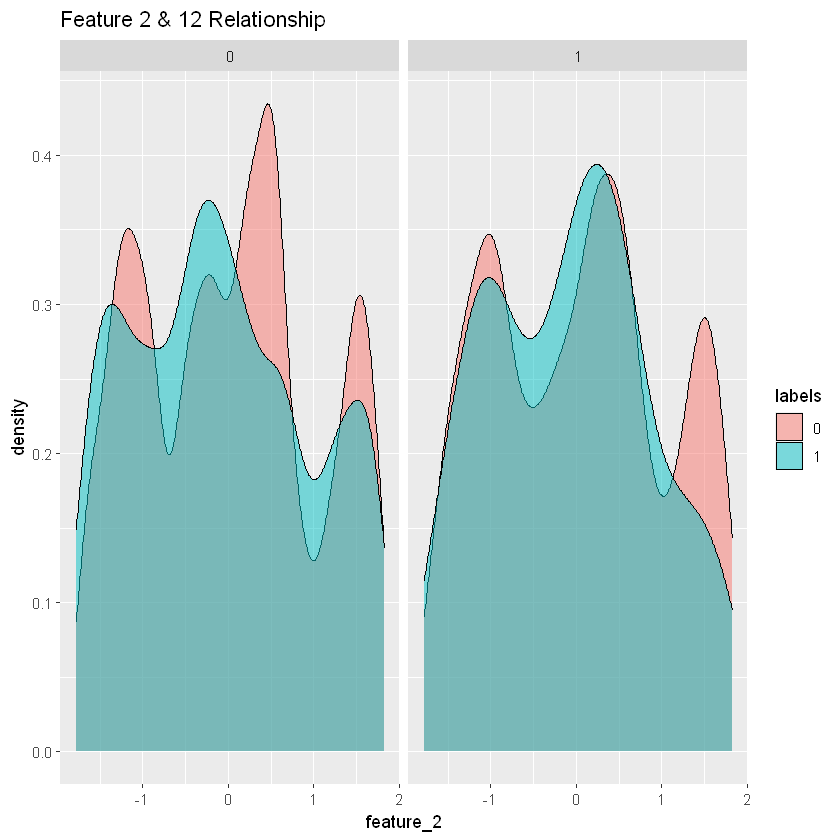

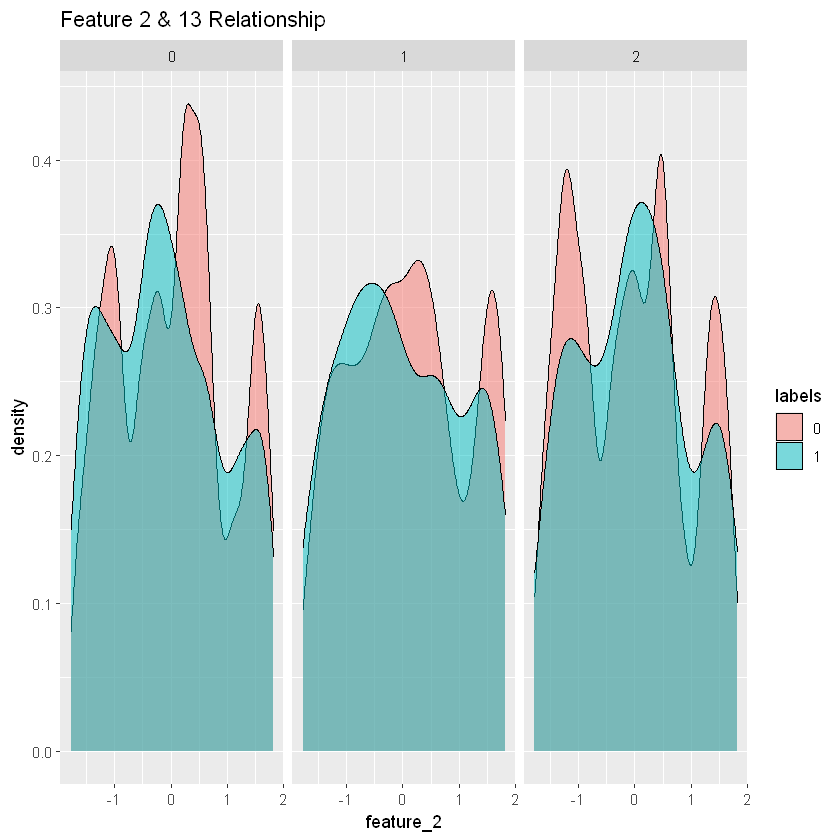

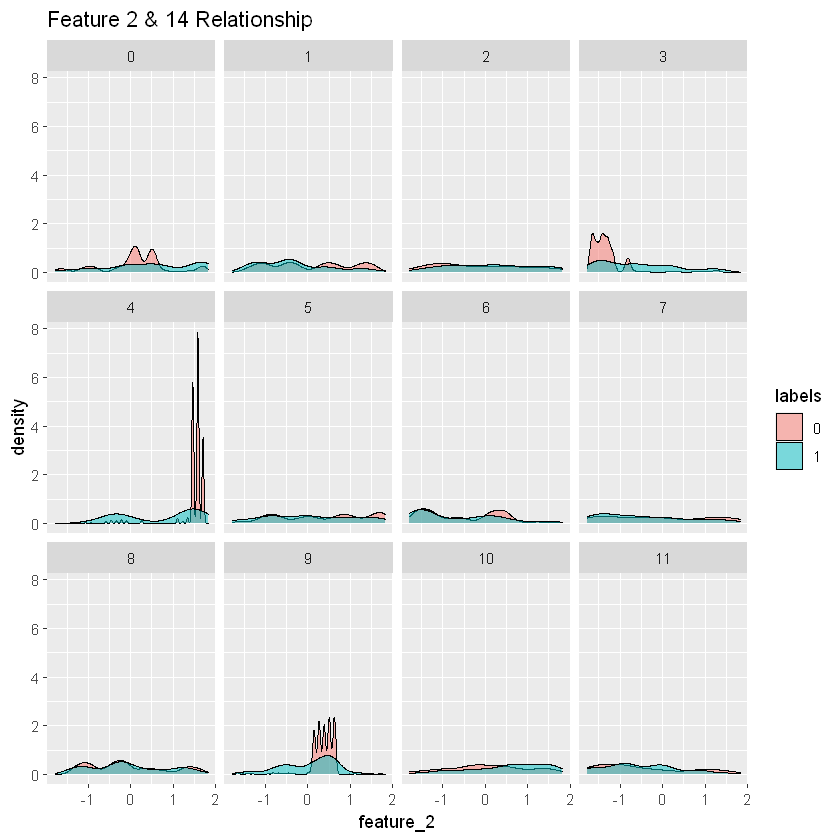

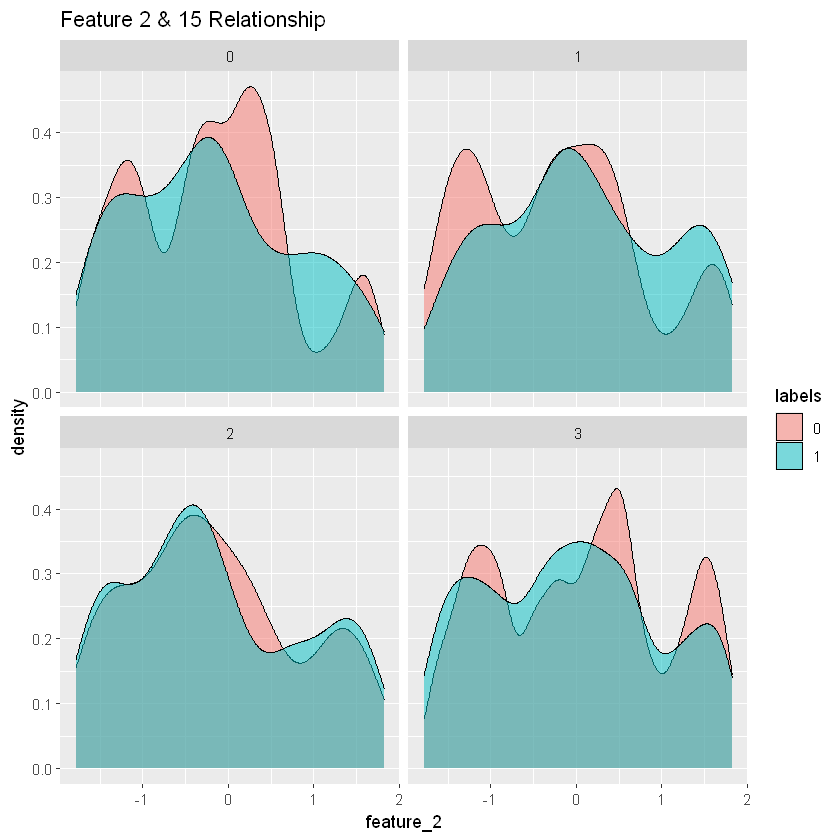

In [203]:
ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_7) +
    ggtitle('Feature 2 & 7 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_8) +
    ggtitle('Feature 2 & 8 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_9) +
    ggtitle('Feature 2 & 9 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_10) +
    ggtitle('Feature 2 & 10 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 2 & 11 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_12) +
    ggtitle('Feature 2 & 12 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_13) +
    ggtitle('Feature 2 & 13 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_14) +
    ggtitle('Feature 2 & 14 Relationship')

ggplot(aes(x=feature_2),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_15) +
    ggtitle('Feature 2 & 15 Relationship')

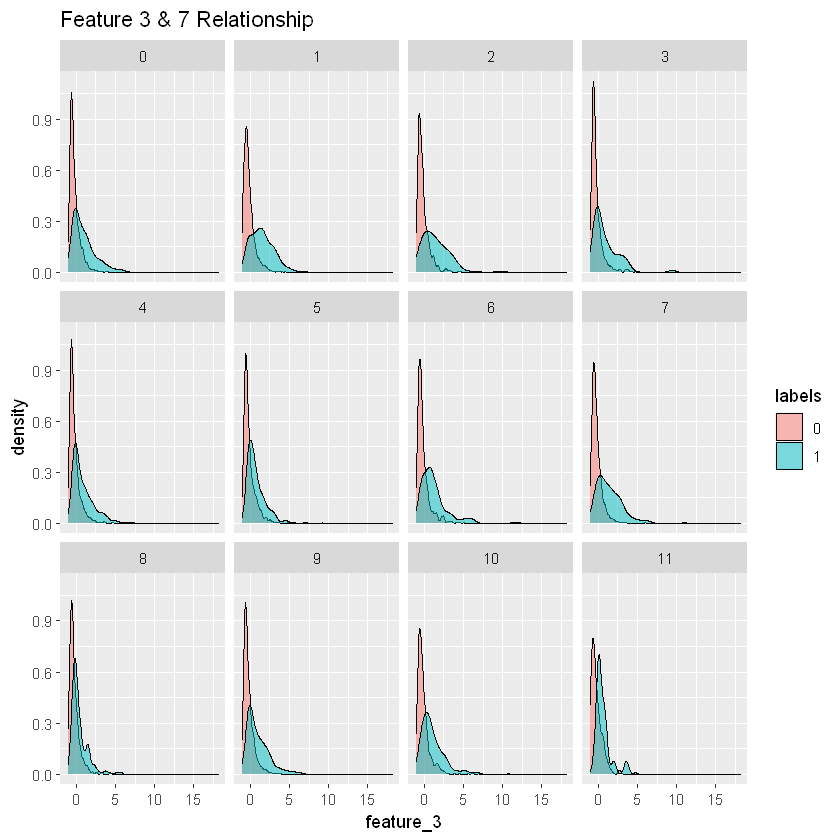

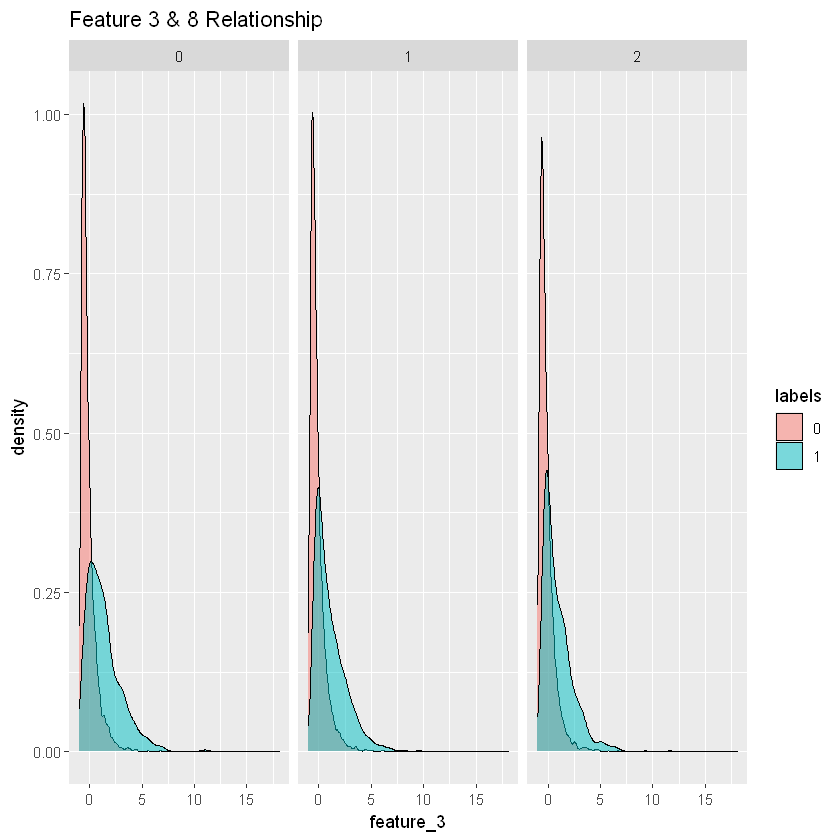

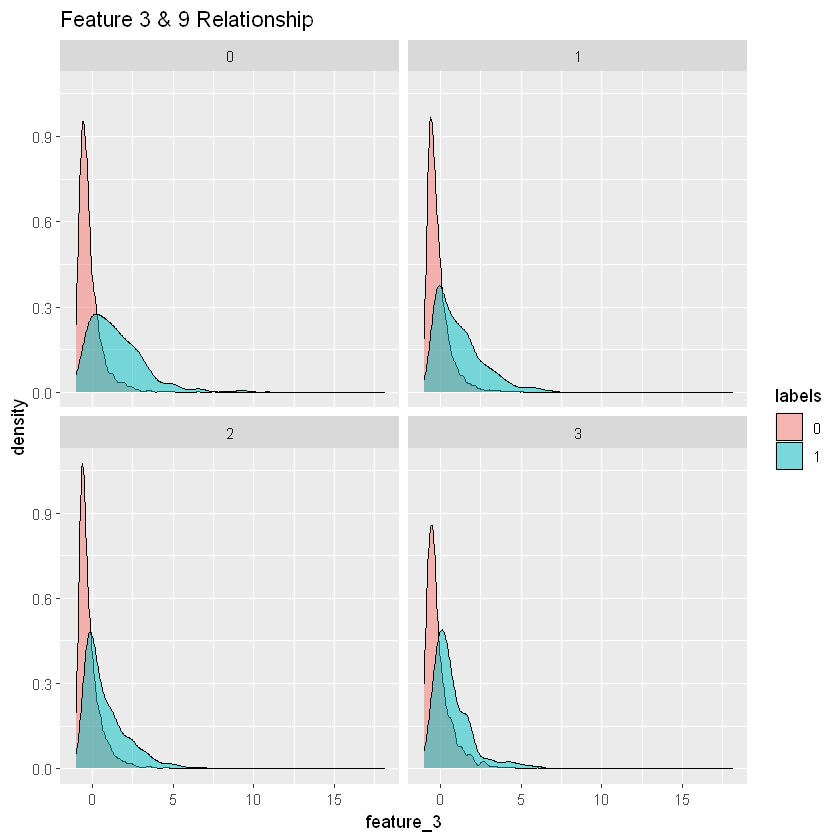

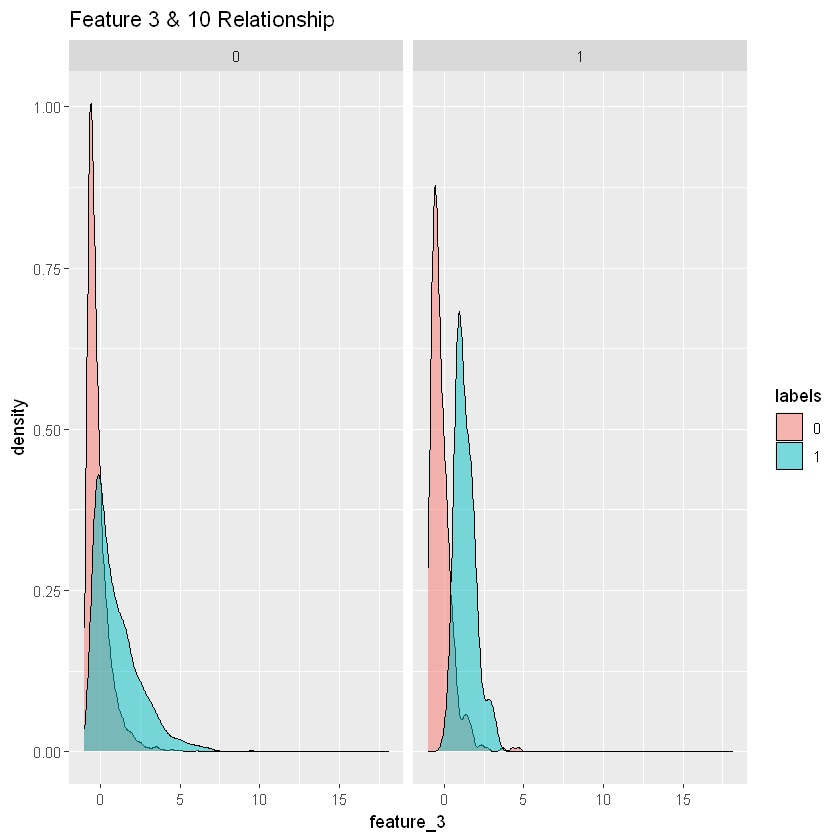

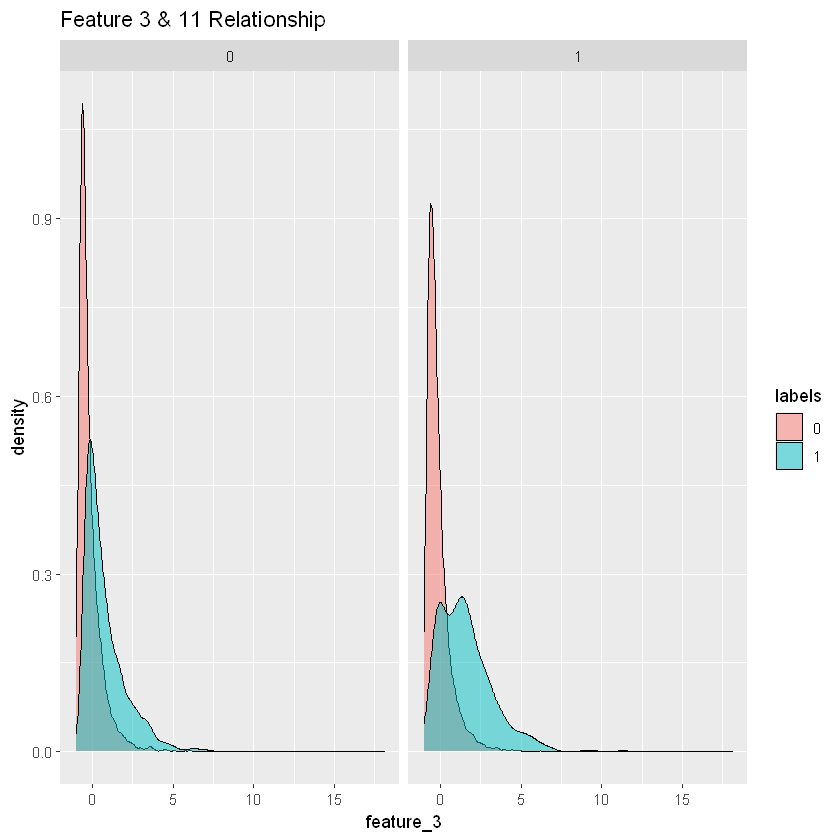

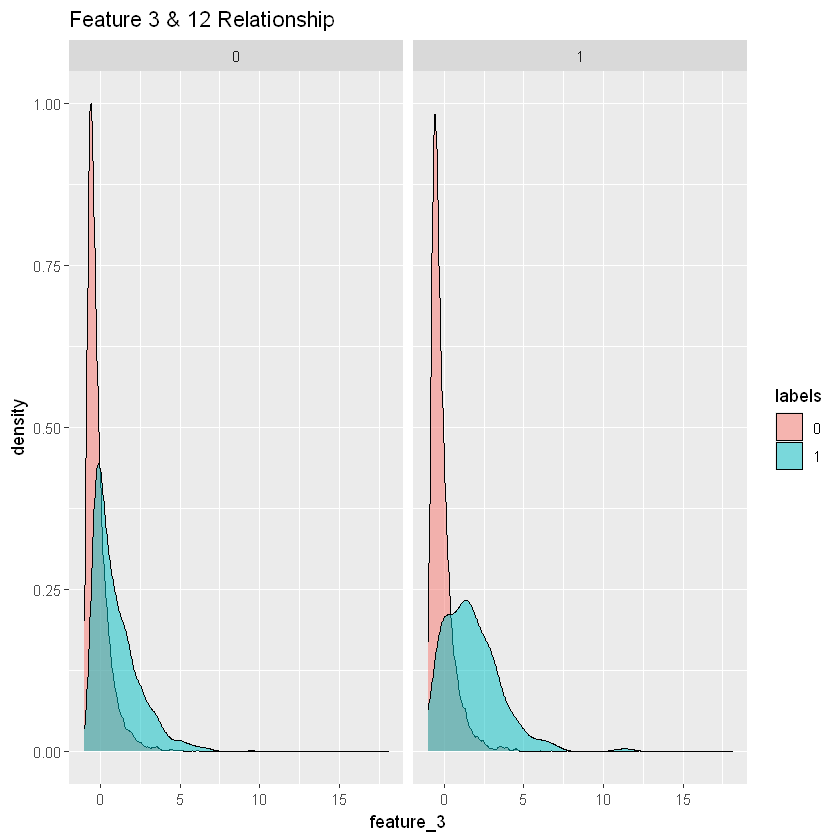

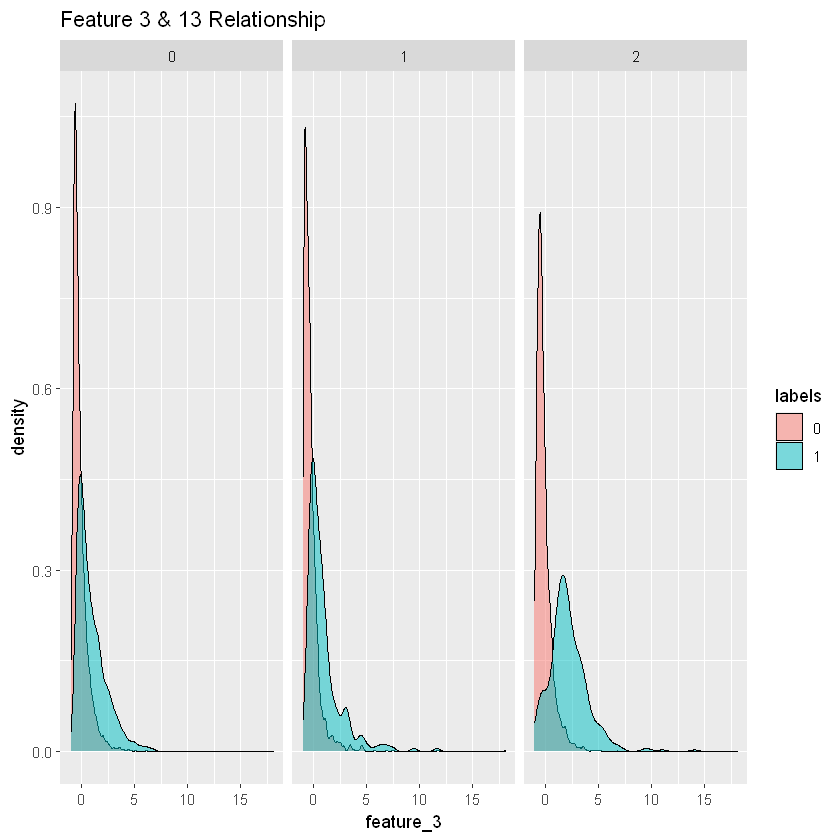

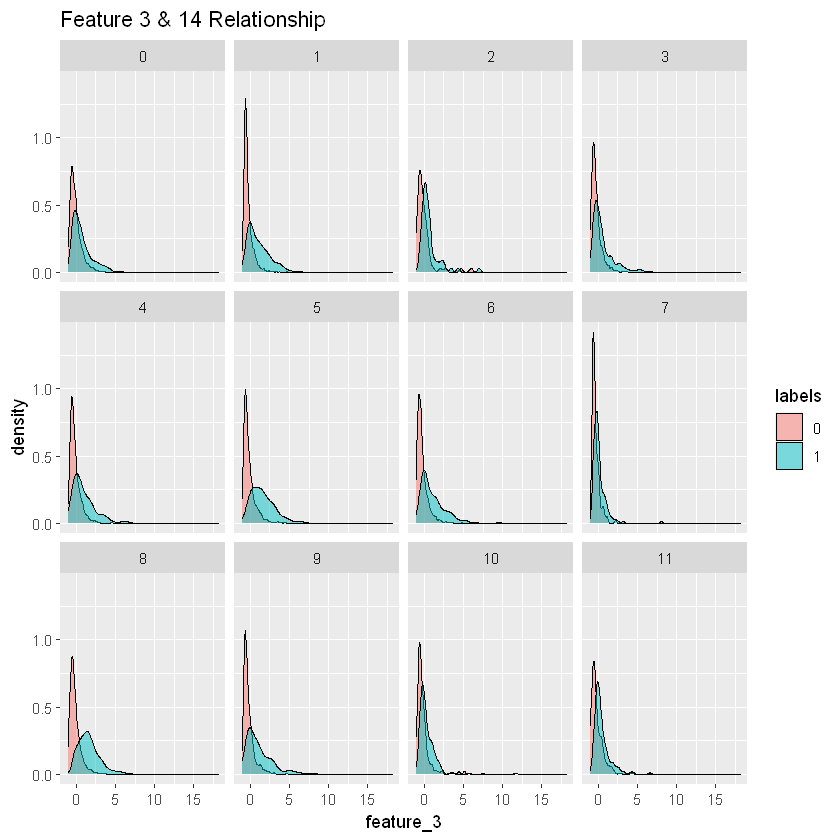

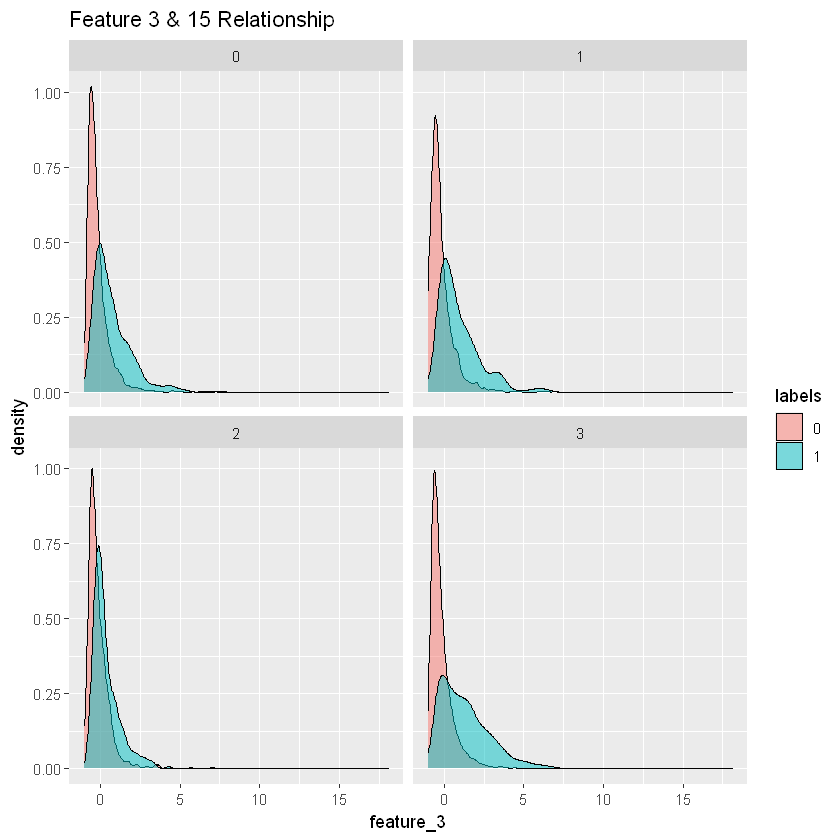

In [204]:
ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_7) +
    ggtitle('Feature 3 & 7 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_8) +
    ggtitle('Feature 3 & 8 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_9) +
    ggtitle('Feature 3 & 9 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_10) +
    ggtitle('Feature 3 & 10 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 3 & 11 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_12) +
    ggtitle('Feature 3 & 12 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_13) +
    ggtitle('Feature 3 & 13 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_14) +
    ggtitle('Feature 3 & 14 Relationship')

ggplot(aes(x=feature_3),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_15) +
    ggtitle('Feature 3 & 15 Relationship')

Warning message:
"Removed 200 rows containing non-finite values (stat_density)."

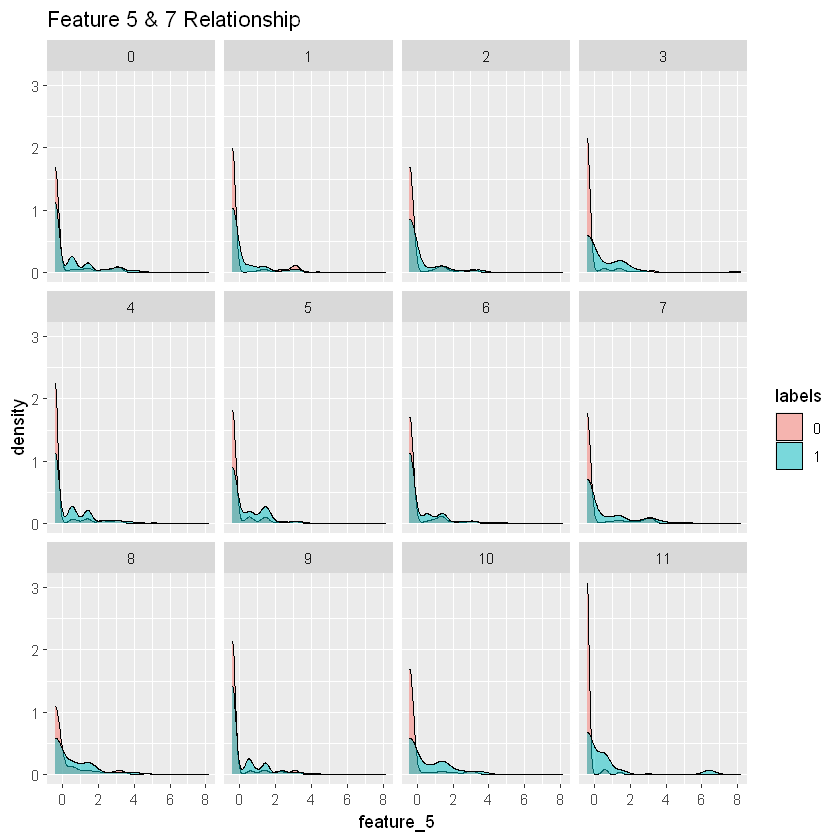

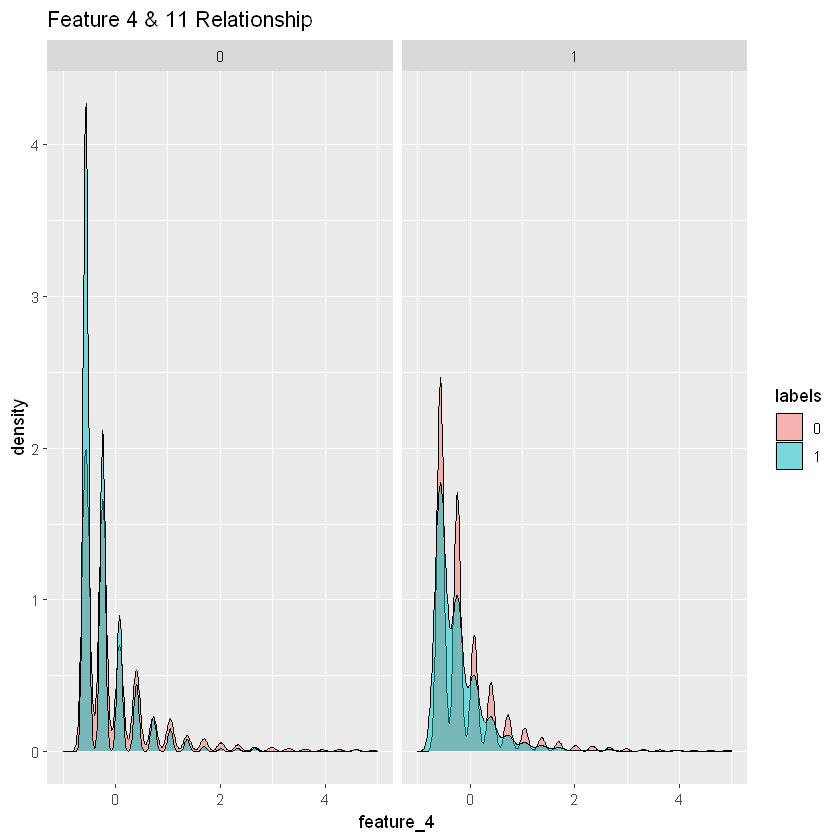

In [205]:
ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_7) +
    ggtitle('Feature 5 & 7 Relationship')

ggplot(aes(x=feature_4),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 4 & 11 Relationship')+
    xlim(-1,5)

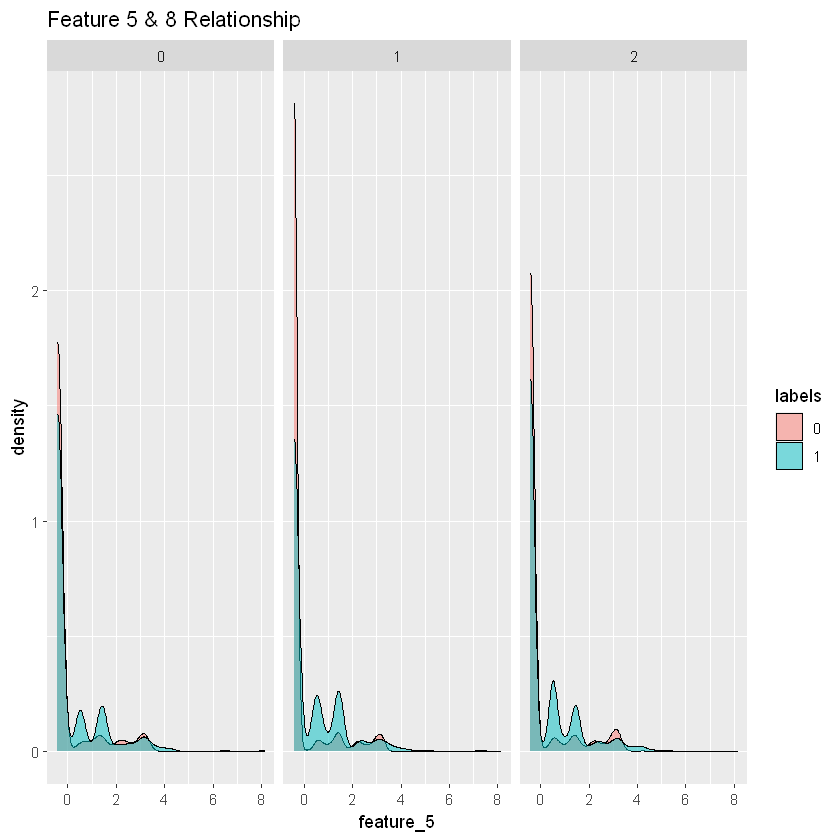

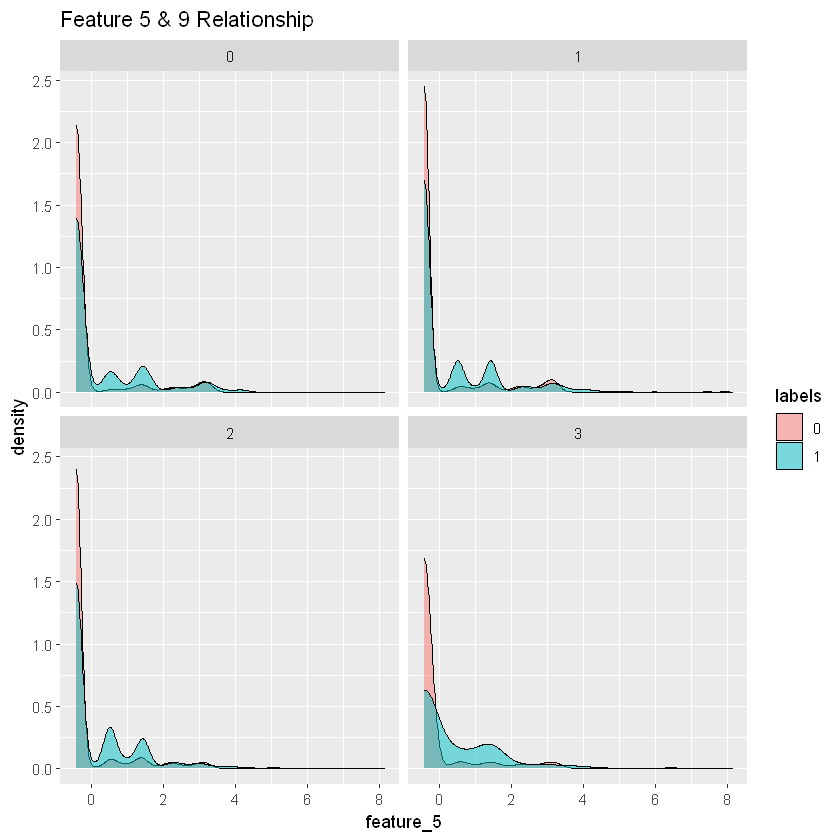

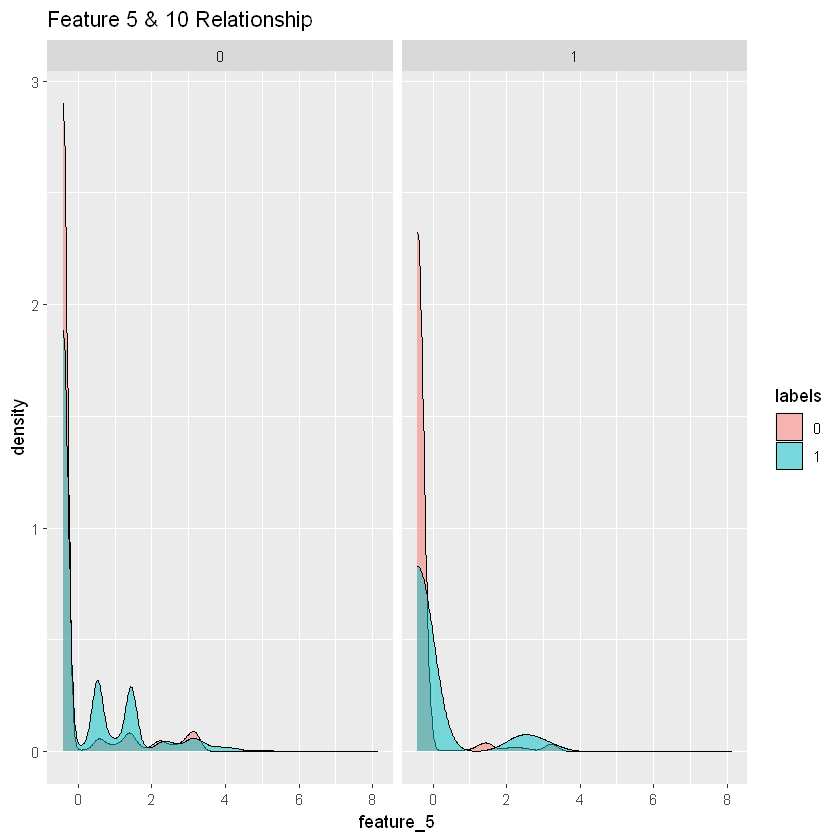

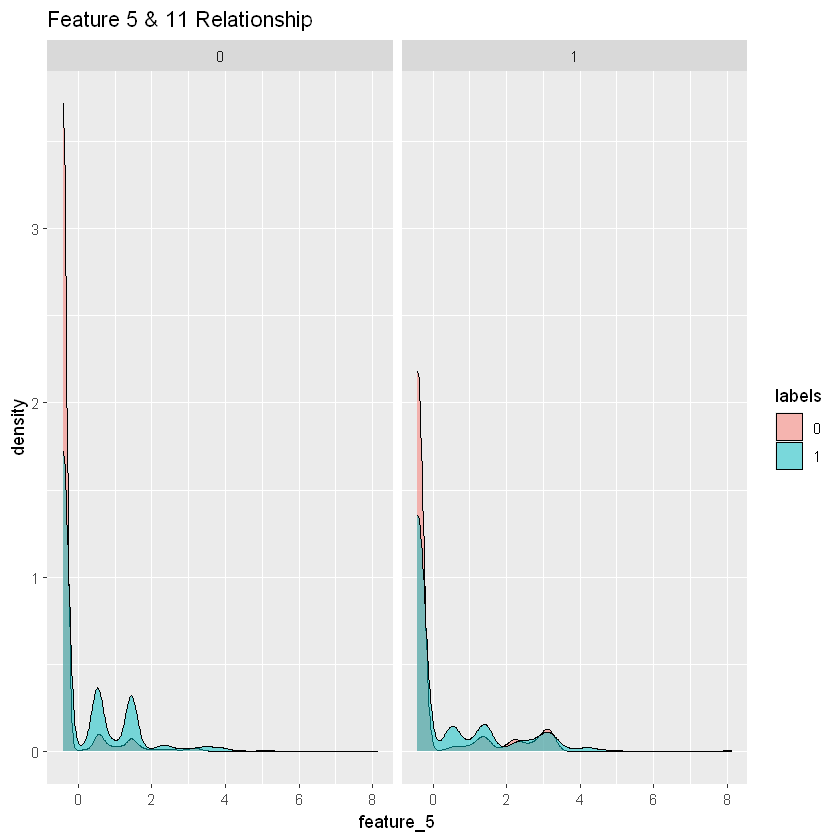

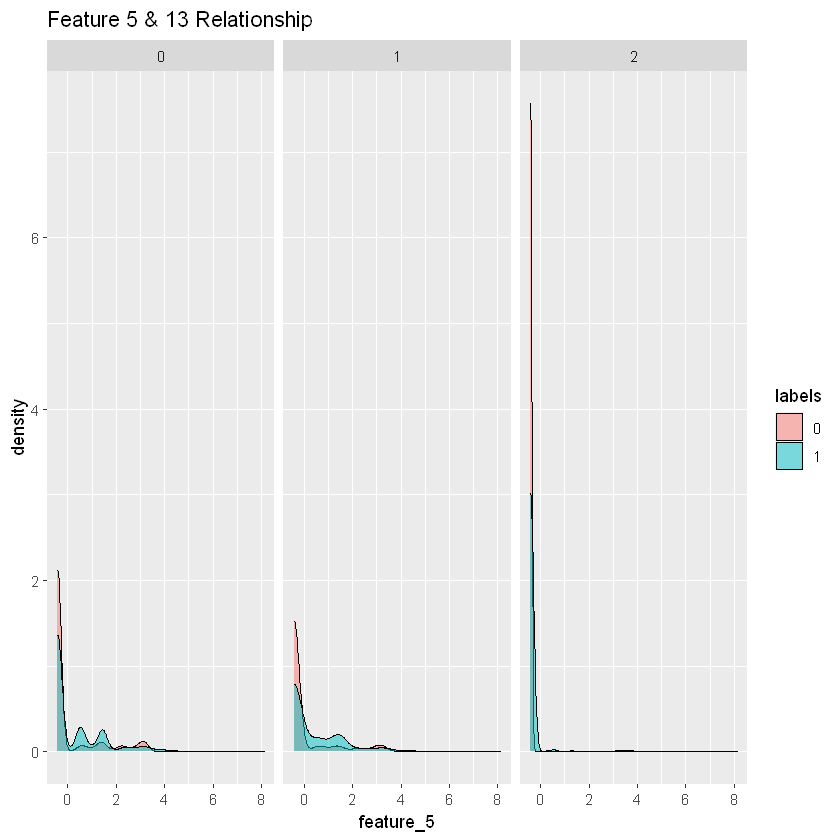

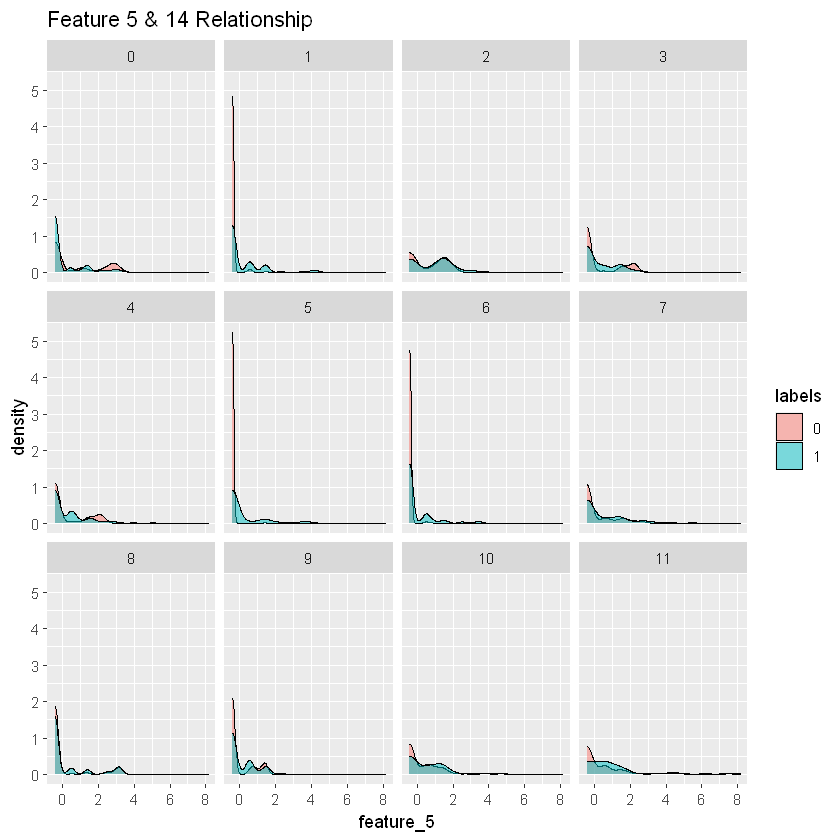

In [206]:
ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_8) +
    ggtitle('Feature 5 & 8 Relationship')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_9) +
    ggtitle('Feature 5 & 9 Relationship')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_10) +
    ggtitle('Feature 5 & 10 Relationship')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 5 & 11 Relationship')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_13) +
    ggtitle('Feature 5 & 13 Relationship')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_14) +
    ggtitle('Feature 5 & 14 Relationship')

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

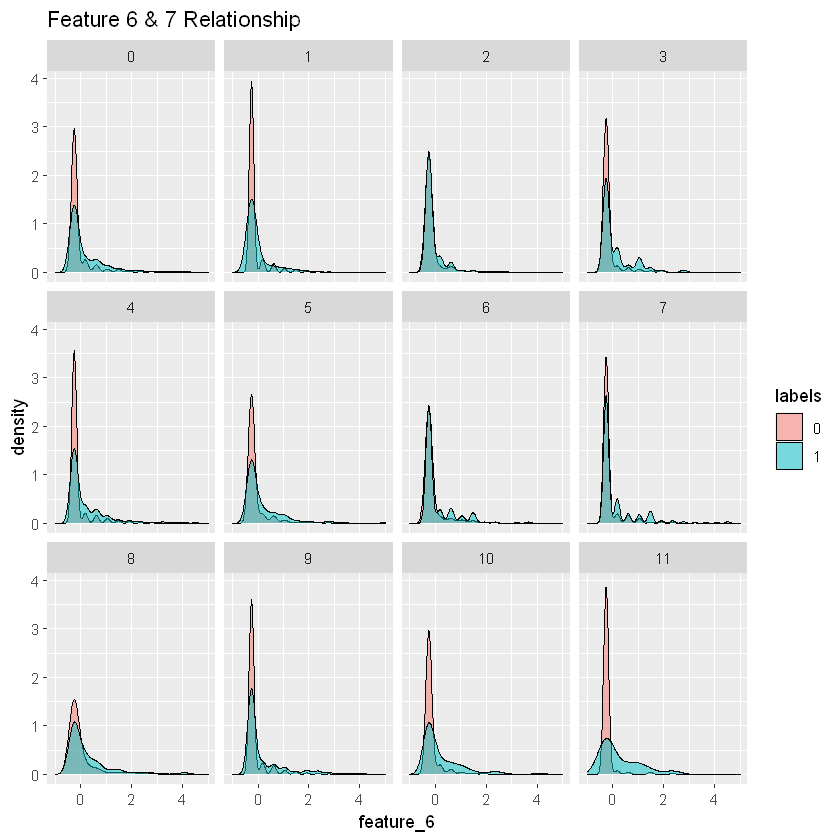

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

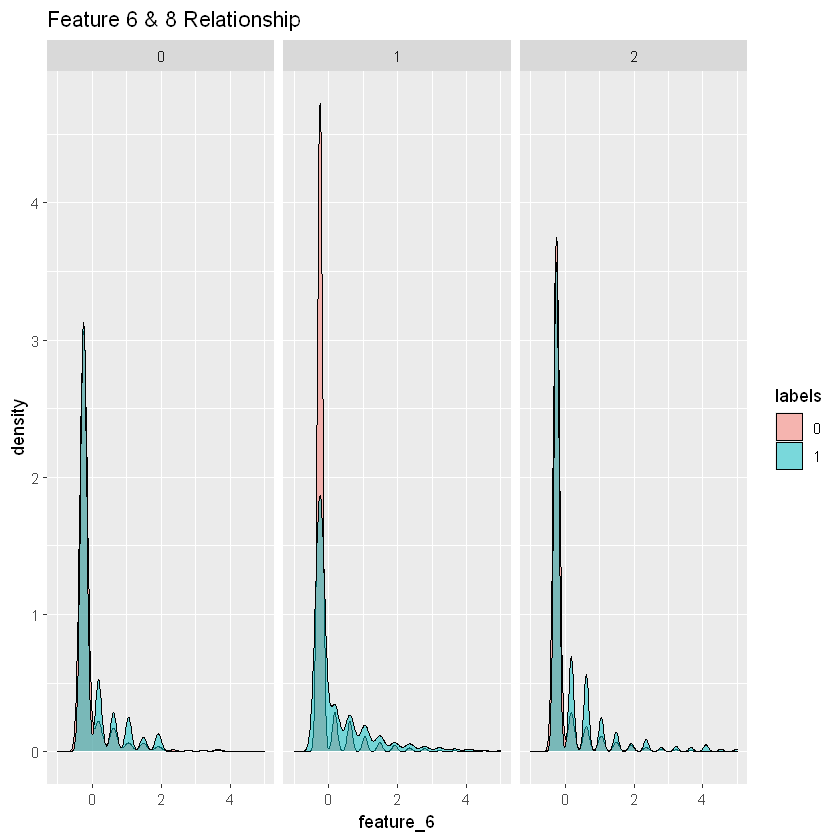

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

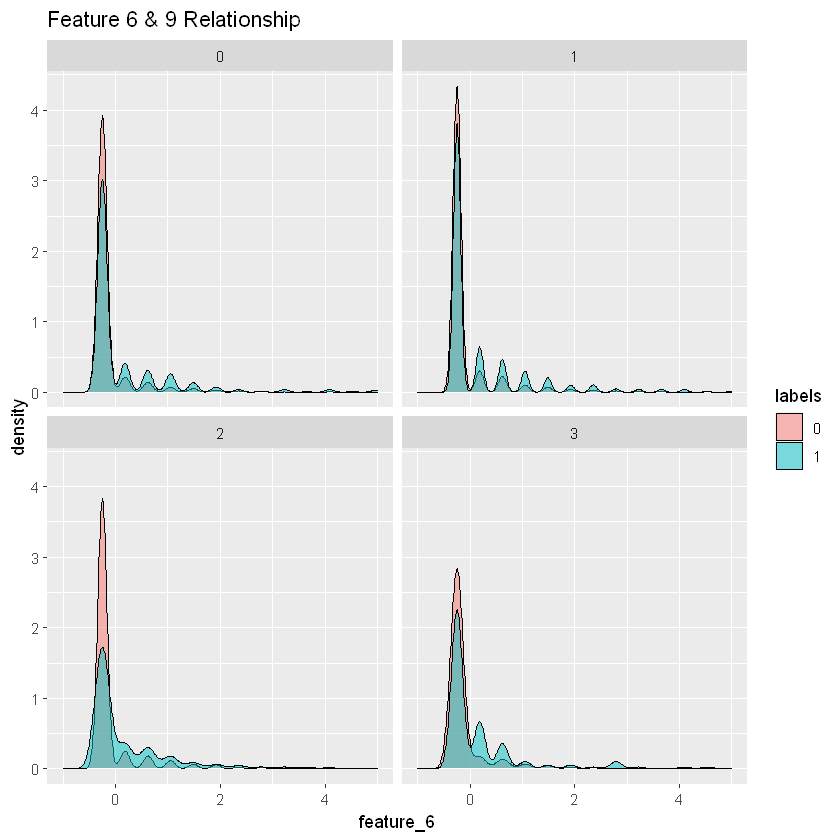

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

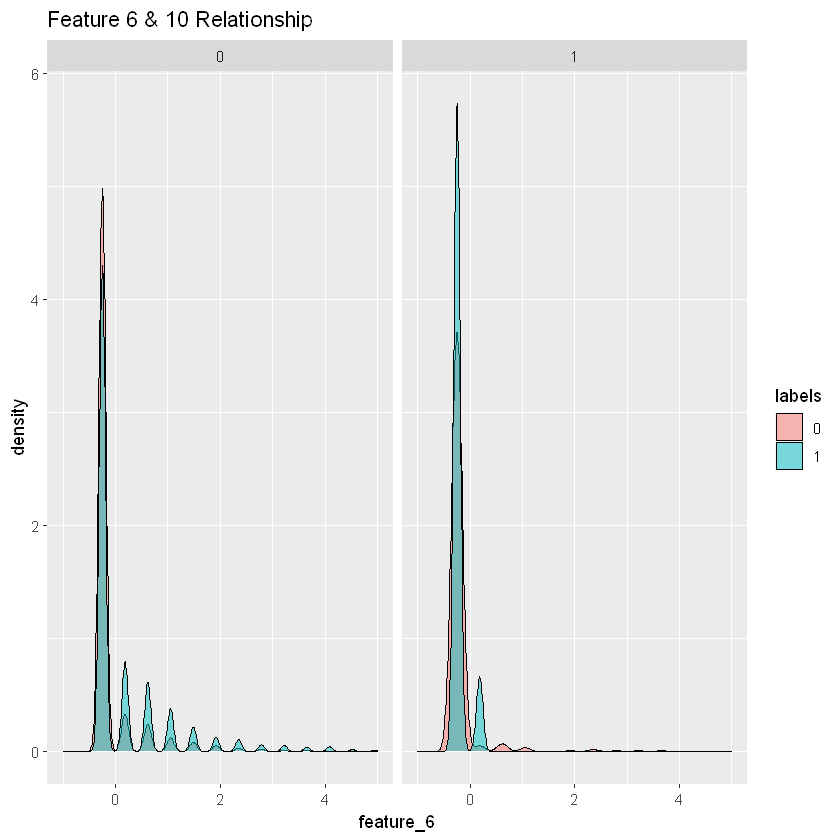

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

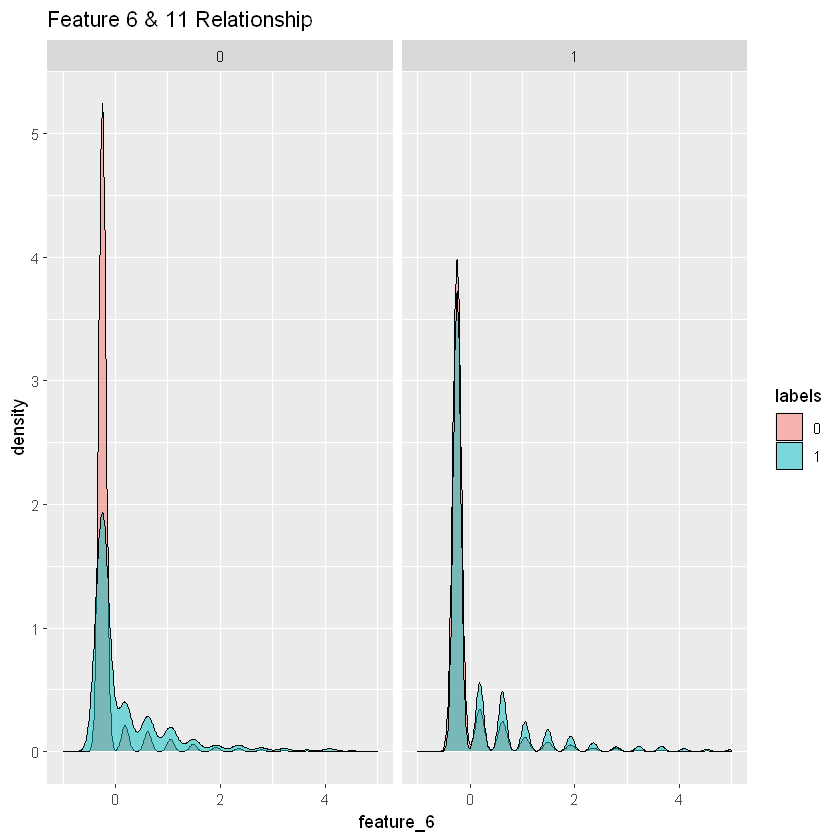

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

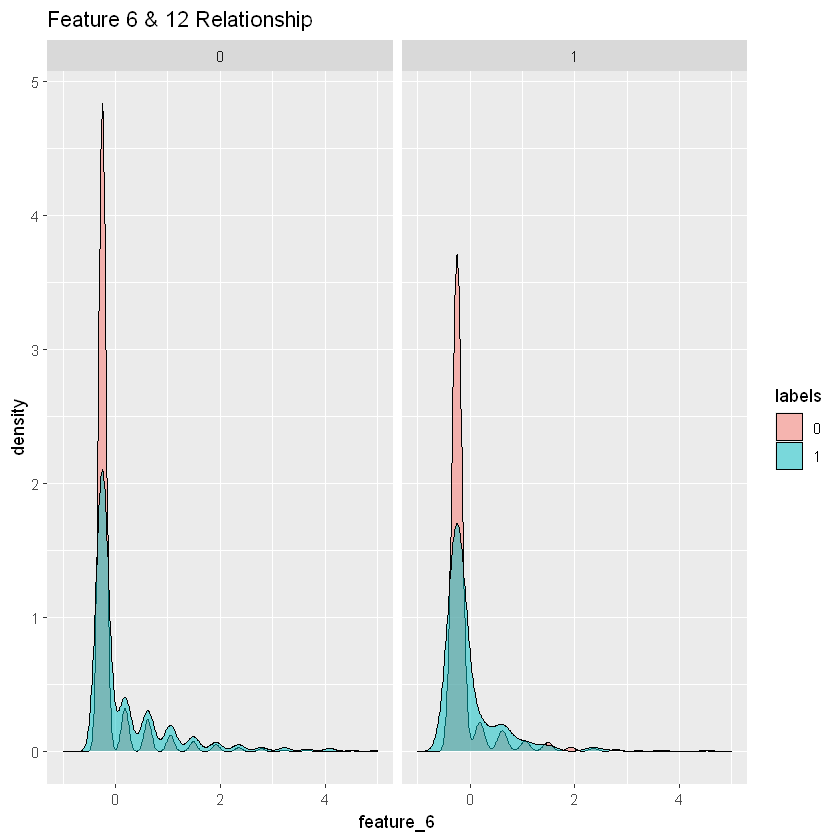

Warning message:
"Removed 99 rows containing non-finite values (stat_density)."

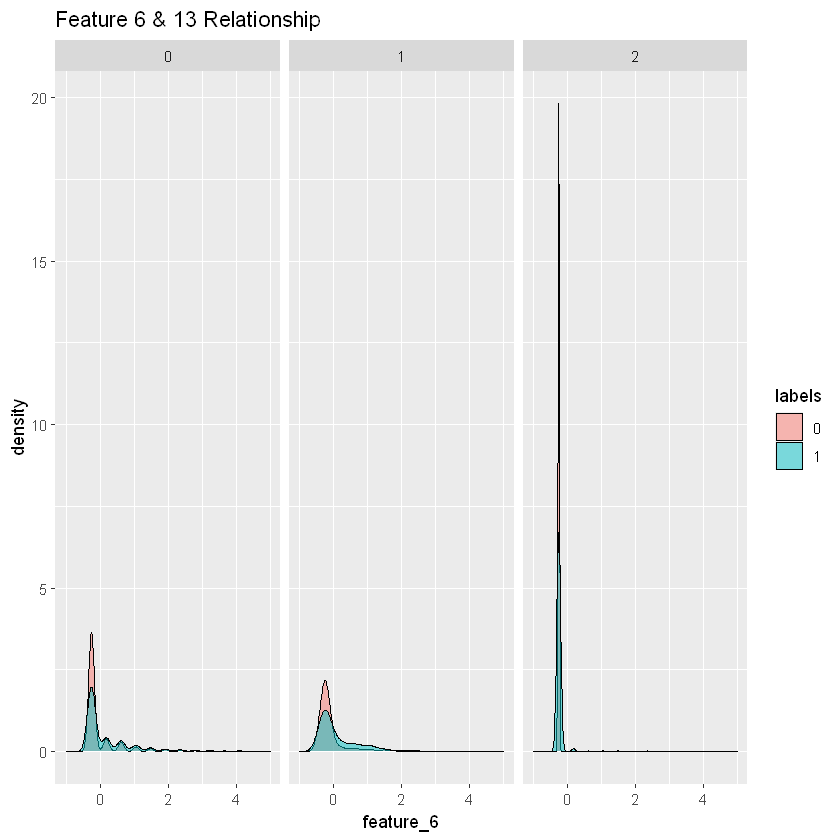

Warning message:
"Removed 24177 rows containing non-finite values (stat_density)."Warning message:
"Groups with fewer than two data points have been dropped."Warning message:
"Groups with fewer than two data points have been dropped."Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"

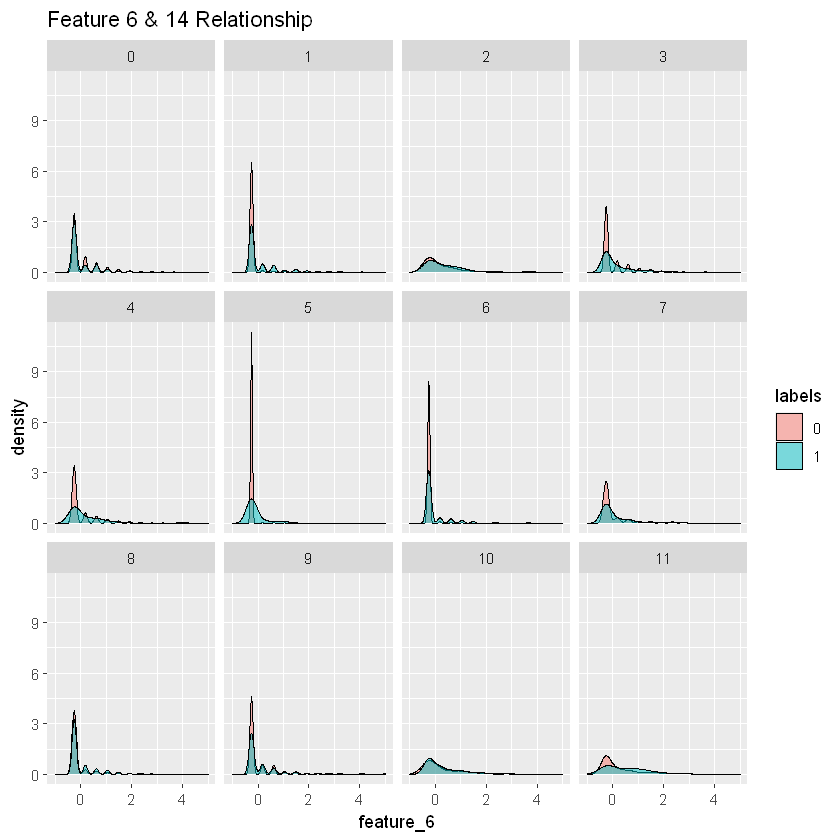

Warning message:
"Removed 4935 rows containing non-finite values (stat_density)."

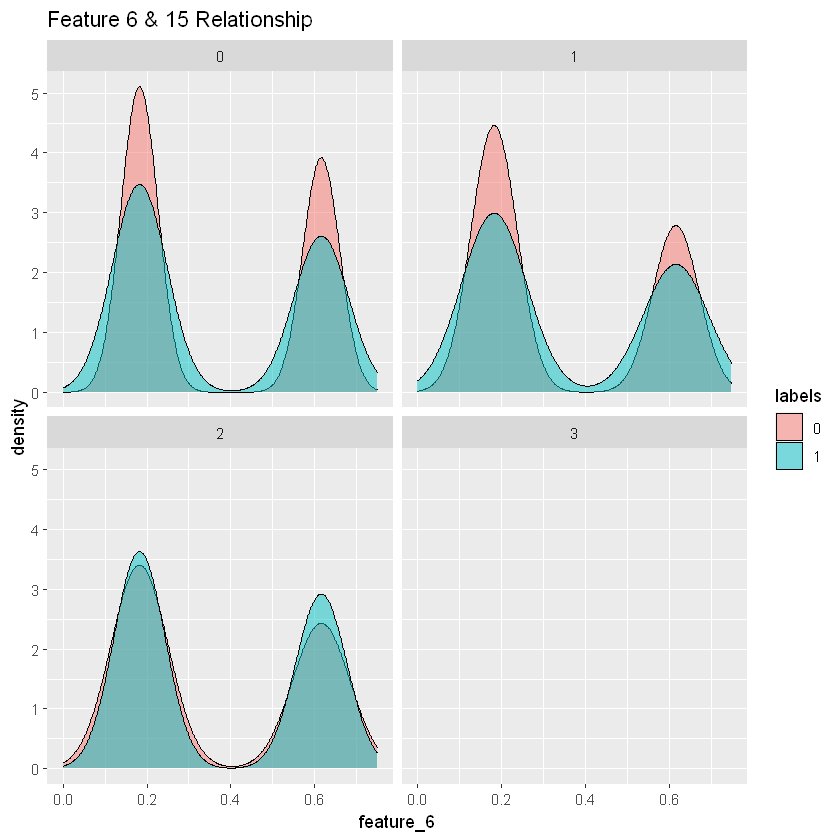

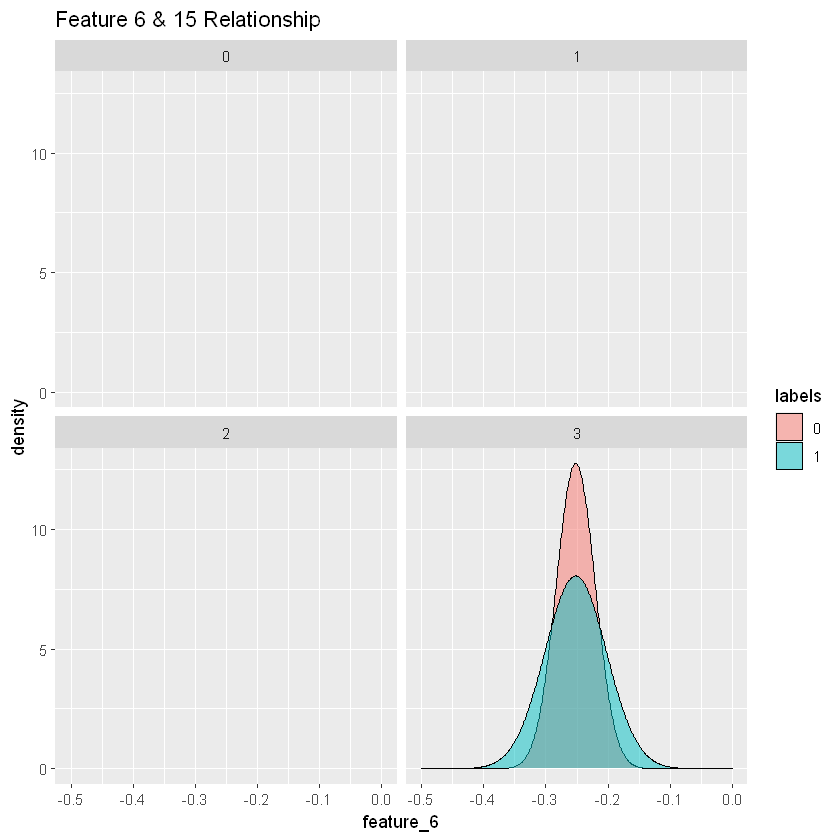

In [208]:
ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_7) +
    ggtitle('Feature 6 & 7 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_8) +
    ggtitle('Feature 6 & 8 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_9) +
    ggtitle('Feature 6 & 9 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_10) +
    ggtitle('Feature 6 & 10 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_11) +
    ggtitle('Feature 6 & 11 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_12) +
    ggtitle('Feature 6 & 12 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_13) +
    ggtitle('Feature 6 & 13 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_14) +
    ggtitle('Feature 6 & 14 Relationship')+
    xlim(-1,5)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_15) +
    ggtitle('Feature 6 & 15 Relationship')+
    xlim(0,0.75)

ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels), alpha=.5) +
    facet_wrap(~feature_15) +
    ggtitle('Feature 6 & 15 Relationship')+
    xlim(-0.5,0)

It seems like this should be used to compare variables that we already thought showed promise?

<div class="alert alert-block alert-success">

### 2.6. Summary of Multivariate Analysis <a class="anchor" name="SumMultivariate"></a>

<div class="alert alert-block alert-success">

### 2.3. More <a class="anchor" name="More"></a>

Assess Linearity?
- Residuals Plot
- Constant variance
- Residuals vs Leverage
- Cooks distance / high leverage variables, remove?
Assess Normality?
- QQ Plot
Model Fit
- ANOVA

Linearity assumptions

<div class="alert alert-block alert-success">

### 2.4. EDA Summary <a class="anchor" name="Summary"></a>

Univariate 
- small vs wide variance
- Normality
- Skew, should it be fixed?
Bivariate
- How much information do they share?
- Colinear label and feature makes a very important feature, lower coreltation less so
- If classes appear to be very seperate, linear model could be good, otherwise maybe a more complex model

<div class="alert alert-block alert-success">

<br>
    
## 3. Model Development <a class="anchor" name="MD">
    
<br>
    
</a>

- Explain choice of model


Choices are:
- LDA
- QDA
- Logistic
- KNN

Say something like: The data relationships looked very complex, so non linear methods were chosen. Or the linear relationships were very strong, so we chose logistic regression.


<div class="alert alert-block alert-success">

<br>
    
## 4. Model Scoring on Test Data <a class="anchor" name="MScore">
    
<br>
    
</a>

Use Pre, recall, etc. ROC, F1

<div class="alert alert-block alert-warning">

<br>
    
## 5. Model Interpretation and Inference<a class="anchor" name="MInterp">
    
<br>
    
</a>

Comment on accuracy etc
Interpretability
For similarly scoring models, factor in time to run and complexity
What are the hyperparameters and what do they mean

From the reading material:
Understanding the association between X1, X2, X3, etc. and Y (Page 19)
- Which predictors are associated with the response?
- What is the relationship between the response and each predictor? (Is it pos/neg correlated, is there greater complexity such as one variable depending on the value of another?)
- Can the relationship between Y and each predictor be adequately summarized using a linear equation, or is the relationship more complicated?

<div class="alert alert-block alert-warning">

<br>
    
## 5.1 Variable Importance <a class="anchor" name="VImp">
    
<br>
    
</a>

Read up on shapely value:
https://onezero.blog/machine-learning-model-explanation-using-shapley-values/

<div class="alert alert-block alert-warning">

<br>
    
## 7. Marketing Suggestions <a class="anchor" name="MarktSugst">
    
<br>
    
</a>

What features would you suggest are important. What to do more of or less of? Target Audience (observation ranges) to focus on? Assuming the data represents client characeteristics and behaviour, suggest which features and ranges are most and least ilkely to leave.

<div class="alert alert-block alert-warning">

<br>
    
## 8. Conclusion <a class="anchor" name="Conclusion">
    
<br>
    
</a>

Analysis steps taken and the outcome at each step.

<div class="alert alert-block alert-info">
    
## 9. References <a class="anchor" name="Ref"></a>

<div class="alert alert-block alert-danger">

# Assignment submission ends here - Delete before completion

    
</div>

# Best predictors:
- Corelation: Feature 15 and 5 are highly correlated, 15 and 6 are somewhat similar too, it's possible these pairs carry the same information. We should remove feature 15 or 5 & 6. We will need to look at how each of these relate to our label before deciding which to remove.
- Box plots indicate that there is label dependancy in most features. 0 has a wider distribution in class 1 than 0, distributions in feature 1 are offset from one another, there is an even wider offset in feature 3. Features 4...while 5 and 6 have the same mean but longer tails on label 1 relative to 0.
- Density plots tells us that...
- segmented bar plots tell us...


# Worst Predictors:
- 10 and 12 have low variance, which will likely make them poor predictors.
- Box plots indicate that feature 2 has the least dependancy on label class. 
- Density plots tells us that...
- segmented bar plots tell us...


# Interactions:
- 


# Overall variables of significance and insignificance
- ?

### Model selection and justification
Clearly explained how the models were developed with sufficient supporting information derived from exploratory data analysis and proper statistical diagnostics.

The exploratory analysis and diagnostics logically lead to the development of the models (including attribute/feature selection).

# Modelling

### Model quality comparison
Critically assess the accuracy of the models with in-depth statistical analysis. 

The comparison is logical and solid with an appropriate level of details. 

Demonstrates a high-level of understanding of the differences (i.e., advantages and disadvantages) between the models in regard to the task.

# Summary
Explanation of why the chosen subset of attributes have a significant impact on the prediction of the response variable.
- The subset of attributes leading to the prediction are identified and clearly justified with in-depth statistical analysis.
- The description and accompanying interpretation are comprehensible and convincing, in line with the findings from the model development.

The quality of the Jupiter notebook/ the R Markdown file, quality and readability of the R implementation.
- The Jupyter  Notebook is well structured in a logical order that clearly supports the development of the answers.
- The R code is logically structured and easy to read.
- Concise but precise code comments clearly explain how the code is intended to work.
- The redundant or unnecessary code is excluded from the final submission.


# Questions:
- The Week 2 tutorial explores the relationship between many variables with one another. Are we interested in just the relationships that we wish to predict? Why would we explore other relationships aside from just looking for duplicated information?
- Check for duplicates still?


# Concerns to follow up before modelling
- Resample data to even out label class
- Are categoric data ordinal? Should they be one hot encoded? Specifically look at 7, 8, 9, 13, 14, 15.
- Feature scaling might be needed for some models
- 

# Suggestions
If there is time:
- Convert legends to say Churn / No churn rather than 0/1
- set labels to factor type
- plot pairs to highlight potentially non-linear relationships between variables. The nagain, scatter plots are for numeric & numeric comparison. So only features 0 - 6 should be done.


# Rejection Zone...probably don't need this code but not 100% sure yet.

In [ ]:
# One stop shop, crashes everything...
library(GGally)
ggpairs(train, aes(color = labels)) + theme_bw()

The correlation between each feature and the labels.

I don't think we should use this....

In [ ]:
par(mfrow = c(4,4))
for (i in 1:(length(train) - 1)) {
        plot(train[,i], train$labels, ylab = 'labels', xlab = names(train)[i])
}

There appear to be differences in the distribution of data for each label correlated with features 1, 4 and 6. It is questionable whether this is also the case for 1, 3 and 5. These features should be explored further using geom_density filled by label to distinguish...

Correlation measurements are for the most part relatively low, the top 5 include:
1. -0.855 between features 5 & 15
2. -0.596	between features 15 & 6
3. 0.547	between features  5 & 6
4. -0.405	between features 8 and 0
5. 0.390	between the labels and 3

Remember this only measures the linear relationship between two variables. Visualising with all with a scatter plot could bring other non linear relationship patterns to the surface. These are a bit crowded with so many features though, so we will focus on the top 5 we've highlighted for now.

In [ ]:
par(mfrow = c(2,3))
plot(train$feature_0, train$feature_8, main = "Features 0 & 8", sub = "Cor = -0.405")
plot(train$feature_3, train$labels, main = "Feature 0 & labels", sub = "Cor = -0.390")
plot(train$feature_5, train$feature_6, main = "Features 5 & 6", sub = "Cor = 0.547")
plot(train$feature_5, train$feature_15, main = "Features 5 & 15", sub = "Cor = -0.855")
plot(train$feature_6, train$feature_15, main = "Features 6 & 15", sub = "Cor = -0.596")

We can't really comment on whether we expected these correlations, we just know they're the most significant linear relationships we have found.

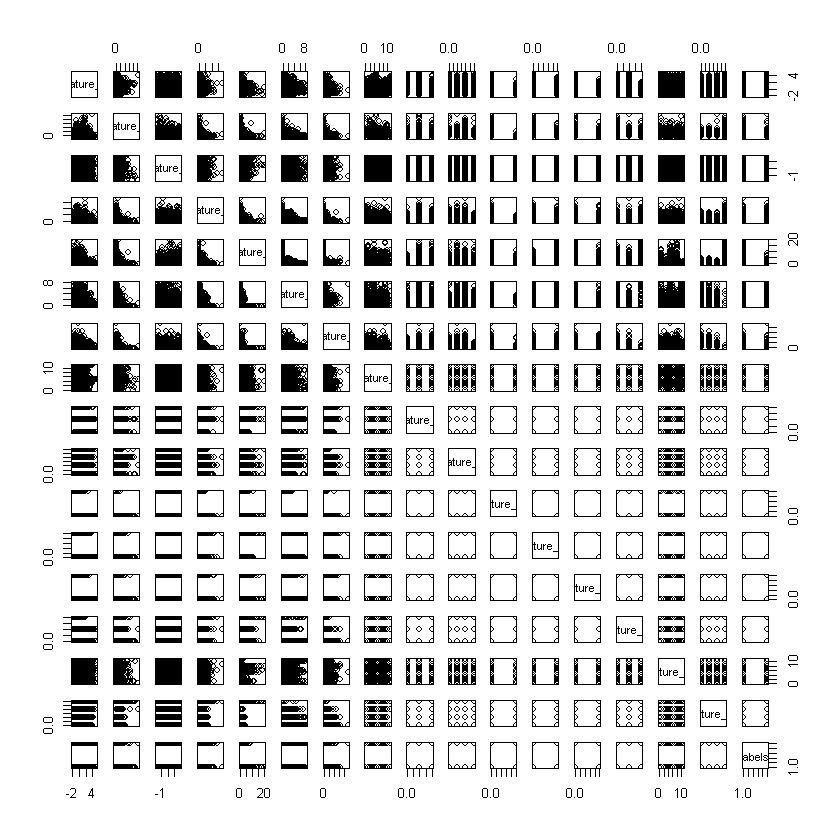

In [34]:
#install.packages("car")
#library("car") 
scatterplotMatrix(train,cex=0.2) 

ERROR: Error in scatterplotMatrix(train, cex = 0.2): could not find function "scatterplotMatrix"
